# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### 1. Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [183]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 


from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [184]:
import os
images_dir = "images"

In [185]:
!pip install category_encoders
from category_encoders import TargetEncoder

### 2. Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [190]:
# cars = pd.read_csv('/Users/chadhas/Desktop/UCB Classes/AI and ML Deep Dive/module 11 Practical application 2/practical_application_II_starter/data/vehicles.csv.zip')

import zipfile

# Path to the zip file
zip_file_path = '/Users/chadhas/Desktop/UCB Classes/AI and ML Deep Dive/module 11 Practical application 2/practical_application_II_starter/data/vehicles.csv.zip'

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Find the CSV file within the zip archive (assuming there's only one CSV file)
    csv_file = [f for f in zip_ref.namelist() if f.endswith('.csv')][0]
    
    # Read the CSV file into a DataFrame
    cars = pd.read_csv(zip_ref.open(csv_file))

    

In [191]:
cars.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [192]:
cars.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
276086,7315849599,new york city,0,2019.0,honda,cr-v,NaN,NaN,gas,25626.0,clean,automatic,2HKRW2H52KH601952,NaN,NaN,SUV,orange,ny
285705,7310848138,new hampshire,33990,2019.0,ram,promaster 2500 high top,excellent,6 cylinders,gas,44000.0,clean,automatic,3C6TRVDG5KE518193,fwd,NaN,NaN,NaN,nh
92676,7311449078,daytona beach,26990,2016.0,mazda,mx-5 miata grand touring,good,NaN,gas,7512.0,clean,other,JM1NDAD79G0101815,rwd,NaN,other,red,fl
246862,7316175920,las vegas,2500,1997.0,saturn,NaN,good,NaN,gas,109000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,nv
137105,7315087486,spokane / coeur d'alene,36592,2016.0,ford,f150 lariat 4x4 1/2 ton gas,NaN,NaN,gas,77819.0,clean,automatic,1FTEW1EF1GKE63500,4wd,NaN,truck,silver,id


### 2.1 Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

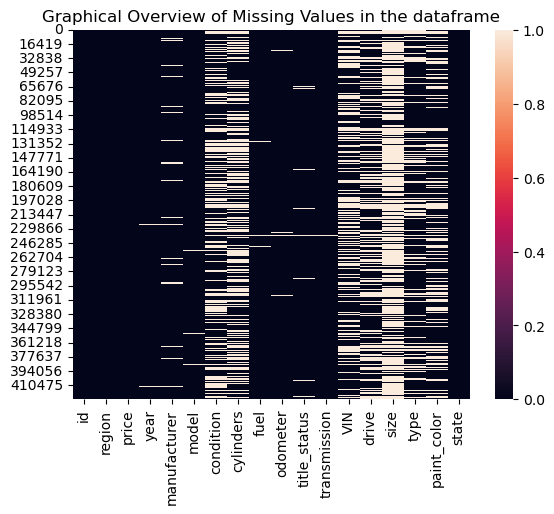

In [193]:
sns.heatmap(cars.isna())

txt ='Graphical Overview of Missing Values in the dataframe'
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.title(txt)
plt.savefig(image_path)


In [194]:
df = cars.copy()
print('Of the ',len(df), 'population of the cars in the dataframe, % NaN values are as follows \n')
round(1e2*df.isna().mean(),2)

Of the  426880 population of the cars in the dataframe, % NaN values are as follows 



id               0.00
region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
VIN             37.73
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
dtype: float64

In [195]:
# Check for key duplicate row and entries 
print('# duplicate rows =', df.duplicated().sum())
print('# duplicate IDs =',  df['id'].duplicated().sum())
print('# duplicate VIN =',  df['VIN'].duplicated().sum())
# ID can be used for indexing the dataframe but decided to drop the Vin and ID values from the dataframe. 

# duplicate rows = 0
# duplicate IDs = 0
# duplicate VIN = 308633


In [196]:
print(df.shape)

print(round(1e2*df['VIN'].duplicated().sum()/len(df),2),'% duplicate VIN entries found. We investigate it here.')

# VIN is unique entry delete duplicates. 
# Hypothesis Example: It may arise by advertizing a car at multiple platform 

VINfilter = df.sort_values(['condition', 'title_status', 'drive', 'size', 'type'])['VIN'].duplicated()
VINfilter.sum()

df = df.loc[VINfilter.index[~VINfilter]]
print(f'Final shape: {df.shape}' )
print(f'# of duplicate VIN values left: {df["VIN"].duplicated().sum()}')


print(df.shape)

(426880, 18)
72.3 % duplicate VIN entries found. We investigate it here.
Final shape: (118247, 18)
# of duplicate VIN values left: 0
(118247, 18)


In [197]:
# Assumption: Dropping ID values from dataframe to decrease the frame size. 
# It can be used at a later date if tracability to the car is needed 
df.drop(columns=['id'], inplace=True)
df.sample(5)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
73697,colorado springs,16999,2011.0,bmw,5 series 535i xdrive,excellent,8 cylinders,gas,72262.0,clean,automatic,WBAFU7C50BC869906,4wd,full-size,sedan,silver,co
378064,lubbock,25900,2014.0,mitsubishi,lancer evolution gsr,excellent,4 cylinders,gas,82750.0,clean,manual,JA32W8FV9EU007052,4wd,NaN,NaN,silver,tx
216203,minneapolis / st paul,3495,2002.0,chevrolet,tahoe,excellent,8 cylinders,gas,213355.0,clean,automatic,1GNEK13Z72R127835,4wd,full-size,SUV,white,mn
132996,boise,5695,2007.0,chevrolet,impala,NaN,NaN,gas,137609.0,clean,automatic,2G1WB58K479396210,fwd,NaN,sedan,white,id
144011,"quad cities, IA/IL",7959,2011.0,gmc,terrain,excellent,4 cylinders,gas,140589.0,clean,automatic,2CTALMEC4B6343415,fwd,NaN,SUV,NaN,il


In [198]:
# Drop rows with NaN in 'odometer','year','fuel','model' 
df = df.dropna(subset=['odometer','year','fuel','model'])

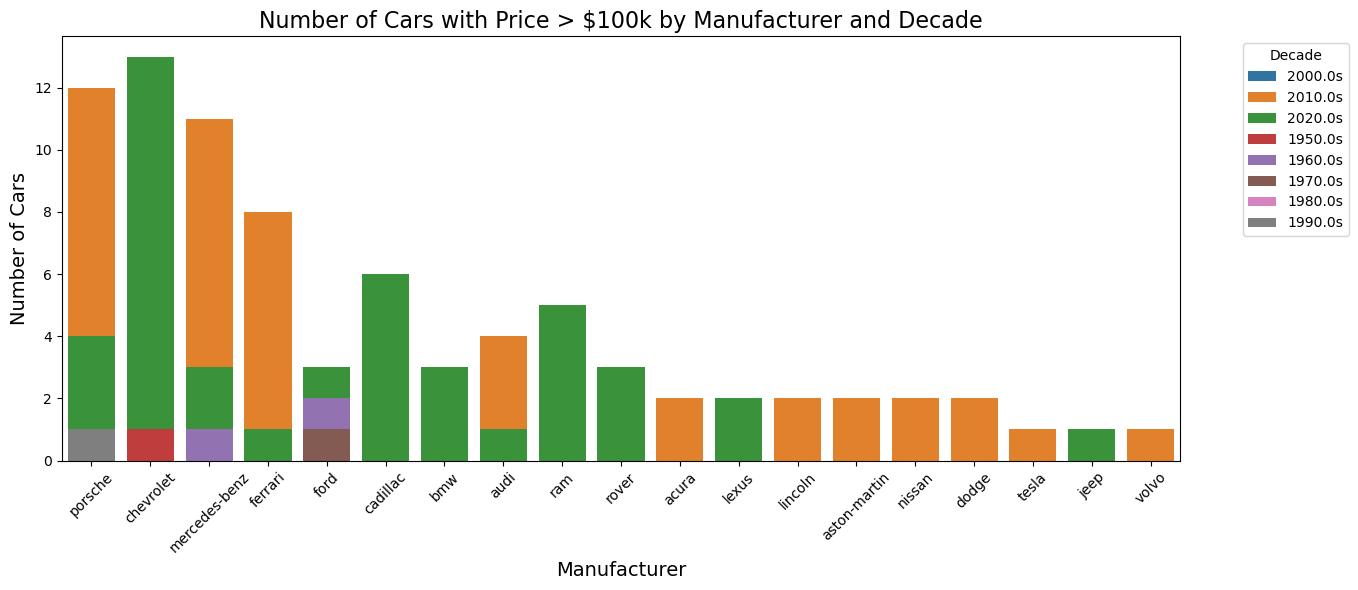

In [199]:
df_filtered = df.query("price > 100000")

# Find the minimum year with price > 100k
min_year_gt_100k = df_filtered.loc[df['price'] > 100000, 'year'].min()

# Determine starting decade
starting_decade = (min_year_gt_100k // 10) * 10

# Create a new column for decade
df_filtered['decade'] = df_filtered['year'] // 10 * 10

# Convert decade values to string representation
df_filtered['decade_str'] = df_filtered['decade'].astype(str) + 's'

# Group by manufacturer and decade, and count the number of cars
manufacturer_decade_counts = df_filtered.groupby(['manufacturer', 'decade_str']).size().reset_index(name='count')

# Sort manufacturers by number of cars
manufacturer_order = manufacturer_decade_counts.groupby('manufacturer')['count'].sum().sort_values(ascending=False).index


txt = 'Number of Cars with Price > $100k by Manufacturer and Decade';
# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=manufacturer_decade_counts, x='manufacturer', y='count', hue='decade_str', order=manufacturer_order, dodge=False, palette='tab10')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xlabel('Manufacturer', fontsize=14)
plt.ylabel('Number of Cars', fontsize=14)
plt.title(txt, fontsize=16)
plt.tight_layout()
plt.legend(title='Decade', bbox_to_anchor=(1.05, 1), loc='upper left')


# # Annotate each segment with decade value
# for p in plt.gca().patches:
# #     plt.gca().annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
# #                        ha='center', va='center', xytext=(0, 5), textcoords='offset points')
#     plt.gca().annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)

In [200]:
print("# Used cars <$100 = ",len(df[df['price'] <= 100]),'corresponding to ',\
      round(1e2*len(df[df['price'] <= 100])/len(df),2),'% of the population of car. <$100 is impractical so we will drop them from the data analysis.')
print("# Used cars >$100k = ",len(df[df['price'] > 100000]),'corresponding to ',\
      round(1e2*len(df[df['price'] > 100000])/len(df),2),'% of the population of car. Thus drop them from the data analysis. These cars can be analyzed separately')

# Used cars <$100 =  12006 corresponding to  10.51 % of the population of car. <$100 is impractical so we will drop them from the data analysis.
# Used cars >$100k =  160 corresponding to  0.14 % of the population of car. Thus drop them from the data analysis. These cars can be analyzed separately


In [201]:
df = df.query("price >100 & price < 100000")

In [202]:
df.describe()

,price,year,odometer
count,102022.000000,102022.000000,1.020220e+05
mean,18479.155084,2012.419233,9.265774e+04
std,13921.296582,6.880438,1.005680e+05
min,101.000000,1905.000000,0.000000e+00
25%,8200.000000,2010.000000,4.243725e+04
50%,14995.000000,2014.000000,8.785350e+04
75%,24999.000000,2017.000000,1.293225e+05
max,99999.000000,2022.000000,1.000000e+07


In [203]:
print(len(df),'total used cars are available for sale with ',df.query("year < 2000").value_counts().sum(),' number of cars from', int(df['year'].min()), 'to 2000')
print('Ignoring the collectors market so we are dropping all cars that are less than 2000 make')

# print(len(df))
df = df.query("year > 2000")
print('New length of dataframe =',len(df))


102022 total used cars are available for sale with  1028  number of cars from 1905 to 2000
Ignoring the collectors market so we are dropping all cars that are less than 2000 make
New length of dataframe = 98508


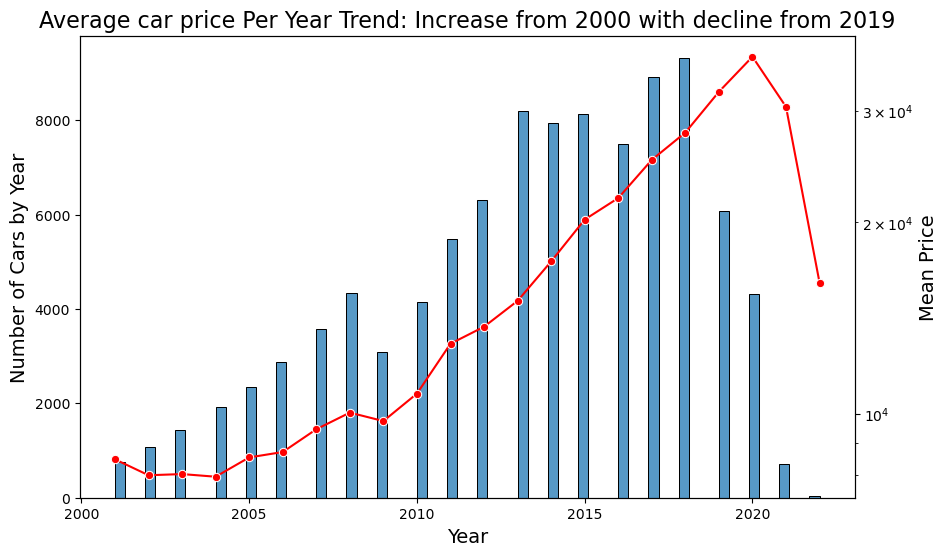

In [204]:
# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

txt = 'Average car price Per Year Trend: Increase from 2000 with decline from 2019';

# Plot histogram with primary y-axis (count of cars based on year)
sns.histplot(data=df, x='year', ax=ax1, kde=False)

# Set labels and title for primary y-axis
ax1.set_ylabel('Number of Cars by Year', fontsize=14)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_title(txt, fontsize=16)

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot line plot with secondary y-axis (mean price of cars)
sns.lineplot(data=df.groupby('year')['price'].mean(), ax=ax2, color='red', marker='o', linewidth=1.5)

# Set labels for secondary y-axis
ax2.set_ylabel('Mean Price', fontsize=14)
# Set secondary y-axis to log scale
ax2.set_yscale('log')

file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)

Overall, the graph suggests a general increase in average car prices over the past two decades. However, it's important to consider the limitations of this graph and explore additional data to get a more comprehensive understanding of car price trends.
 
Some additional points to consider:
The graph considers 2000-2020 timeframe might not capture the most recent trends. Possible Decline in 2019: There appears to be a dip in the average price around 2019. It's difficult to say definitively what caused this without more context, but it could be due to factors like Covid that may have led to economic fluctuations, changes in consumer preferences, or temporary industry trends.

This graph likely represents a general trend, but car prices can vary significantly depending on the region.
The data used to create this graph likely incorporates a variety of car models and makes. The average price might not reflect the price trends for specific categories of cars.

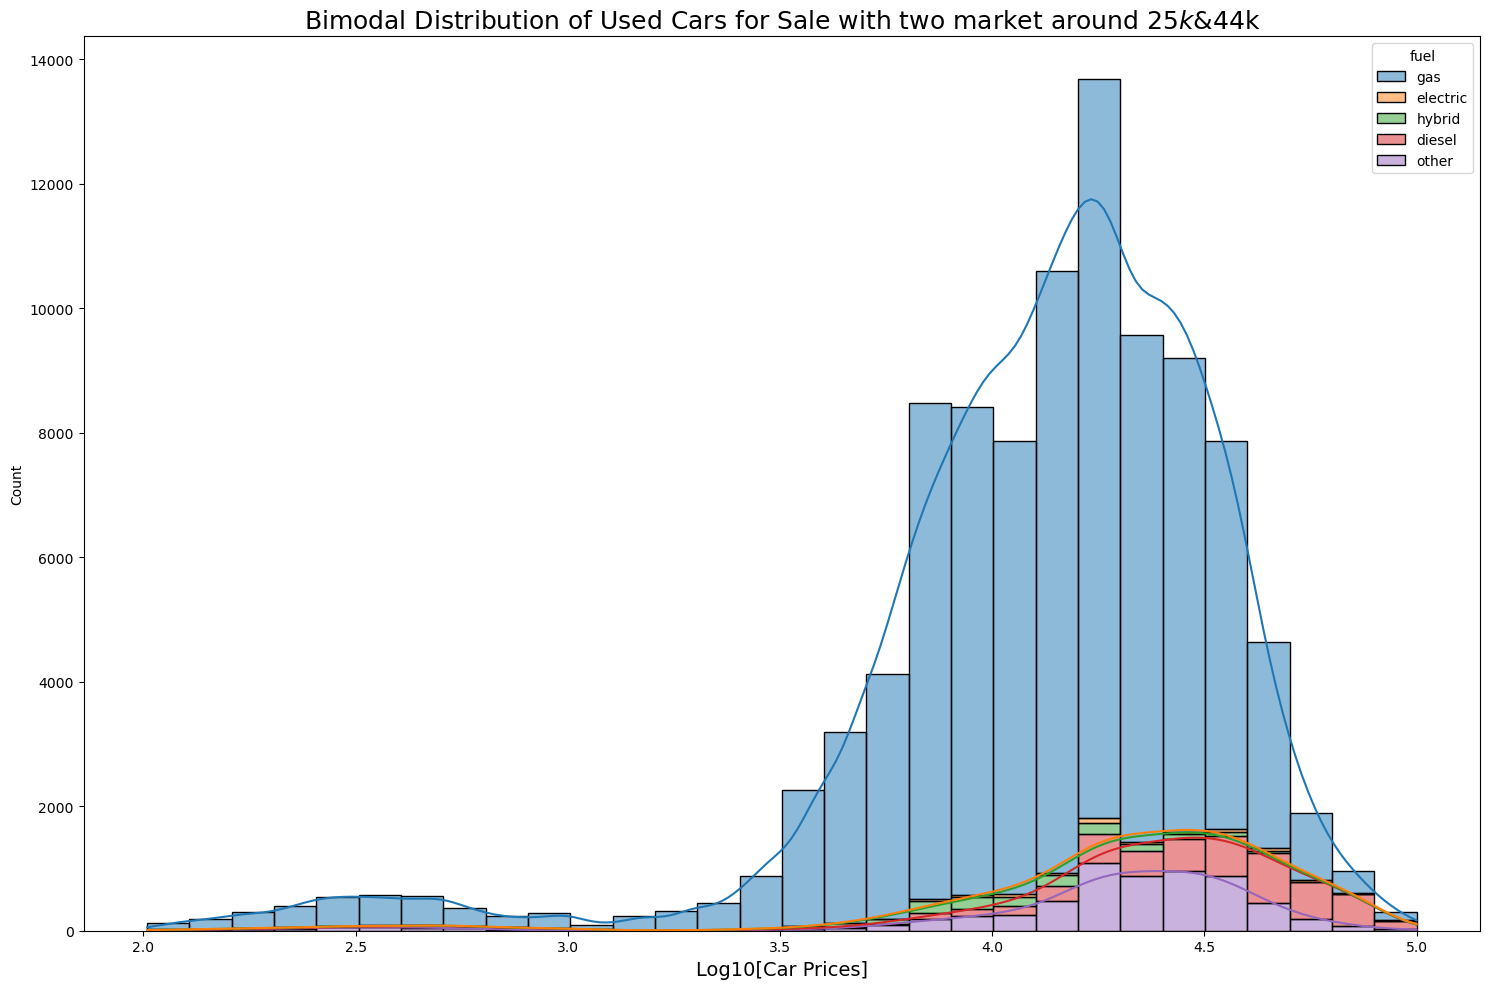

In [205]:
valid_values = df['price'].dropna()
log_values = np.log10(valid_values + 1)  # Apply log10 transformation (adding 1 to avoid log(0))

plt.figure(figsize = (15,10))
txt ='Bimodal Distribution of Used Cars for Sale with two market around $25k & $44k'

sns.histplot(data=df, x=log_values, discrete=False,kde=True, bins =30, hue = 'fuel', multiple="stack")
plt.xlabel('Log10[Car Prices]', fontsize=14)  # Adding x-axis label
plt.title(txt, fontsize=18)  # Adding title
plt.tight_layout()
# plt.show()

file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)

Two Price Segments: The bimodal distribution suggests that there might be two dominant price segments in the used car market. One segment concentrated around `$25,000` and another around `$44,000`.

Market Preferences: The presence of two distinct peaks indicates a potential preference for cars in these two price ranges. This could be due to several factors:

Budget Constraints: Buyers might be concentrated in two budget categories, with a significant number looking for affordable cars around `$25k` and  another group willing to spend more for potentially newer or feature-rich cars around `$44k`.

Car Lifespan: The two peaks might correspond to different lifespans for cars. Cars in the $25k$ range might be older but still functional, while those around $44k could be newer models with more features.
Demand and Availability: The relative heights of the peaks could indicate the relative availability of cars in each price segment. A higher peak could suggest more available cars in that price range.

Further Inferences (depending on data availability):

Car Age: If you have data on car age alongside the price, you could analyze if the `$25k` segment tends to have older cars and the `$44k` segment tends to have newer cars, supporting the lifespan theory.
Car Features: If information on car features is available, you could see if there are distinct feature sets associated with each price range. For instance, cars around $44k might have more luxury features or advanced technology compared to those around `$25k`.
Overall, the bimodal distribution highlights the existence of potential price segments in the used car market, possibly reflecting buyer preferences, budget constraints, or car lifespans. By analyzing additional data about the cars, you can gain more insights into the reasons behind this distribution.

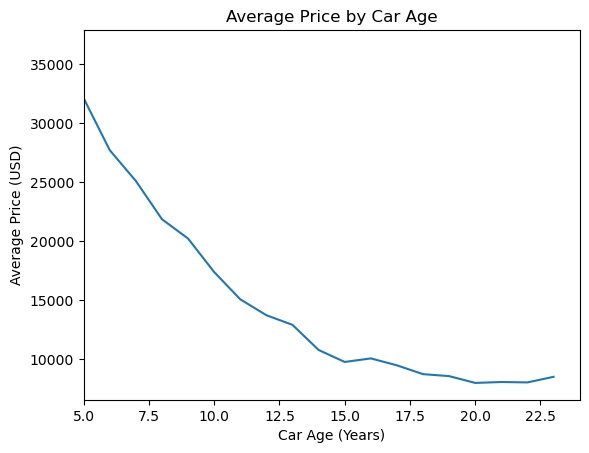

In [206]:
# Calculate car age
used_cars_data = df.copy()
used_cars_data["car_age"] = 2024 - used_cars_data["year"]

# Group analysis by features

# Group by car age and plot average price
car_age_groups = used_cars_data.groupby("car_age")["price"].mean()
plt.plot(car_age_groups.index, car_age_groups.values)
plt.xlabel("Car Age (Years)")
plt.ylabel("Average Price (USD)")
plt.xlim(5, 24)  # Set x-axis limits from 5 to 24
txt = "Average Price by Car Age"
plt.title(txt)

file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)


In [207]:
used_cars_data = used_cars_data.replace({'8 cylinders':8, '6 cylinders':6, '4 cylinders':4, '5 cylinders':5,  \
                 '3 cylinders':3, '10 cylinders':10, '12 cylinders':12,'other':np.nan})
used_cars_data.sample(5)

# Correlation matrix to explore relationships between features and price
correlation_matrix = used_cars_data[["car_age", "odometer", "cylinders", "price"]].corr().round(2)
print(correlation_matrix)
correlation_matrix

           car_age  odometer  cylinders  price
car_age       1.00      0.62       0.15  -0.54
odometer      0.62      1.00       0.12  -0.44
cylinders     0.15      0.12       1.00   0.36
price        -0.54     -0.44       0.36   1.00


,car_age,odometer,cylinders,price
car_age,1.00,0.62,0.15,-0.54
odometer,0.62,1.00,0.12,-0.44
cylinders,0.15,0.12,1.00,0.36
price,-0.54,-0.44,0.36,1.00


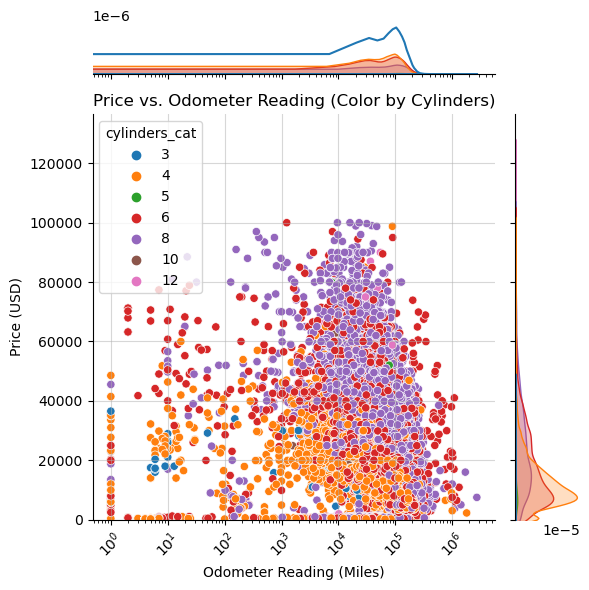

In [208]:
# Valid cylinders and categorical conversion
valid_cylinders = [3,4, 5, 6, 8, 10, 12]
used_cars_data_filtered = used_cars_data[used_cars_data["cylinders"].isin(valid_cylinders)]
used_cars_data_filtered["cylinders_cat"] = pd.Categorical(used_cars_data_filtered["cylinders"])

# Scatter plot with KDE for price and odometer (separate for clarity)
g = sns.jointplot(
    x="odometer",
    y="price",
    data=used_cars_data_filtered,
    hue="cylinders_cat",
    hue_order=valid_cylinders,
    kind="scatter",
)

# Add KDE plots to the margins
sns.kdeplot(used_cars_data_filtered["odometer"], ax=g.ax_marg_x)
# sns.kdeplot(used_cars_data_filtered["price"], ax=g.ax_marg_y)

# Customize the plot
plt.xscale("log")  # Log scale for odometer to better visualize spread
plt.xlabel("Odometer Reading (Miles)")

# Adjust y-axis (price) for readability
# Option 1: Set y-axis limits (assuming price range is known)
# plt.ylim(bottom=0, top=price_range_upper_limit)  # Replace with your price range

# Option 2: Enable grid lines for better estimation
plt.grid(True)

# Title and legend (optional adjustments)
plt.ylabel("Price (USD)")
txt = "Price vs. Odometer Reading (Color by Cylinders)"
plt.title(txt, fontsize=12)

# Truncate price axis to remove negative values (if not filtered earlier)
plt.ylim(bottom=0)  # Set minimum price to 0

# Increase legend font size (optional)
# plt.legend(title="Number of Cylinders", title_fontsize=10, labelfontsize=8)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Adjust grid line transparency
plt.grid(alpha=0.5)  # Adjust alpha value between 0 (invisible) and 1 (opaque)

plt.tight_layout()  # Improve spacing between elements
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)

Impact of Cylinders:
The color gradient from blue (presumably lower number of cylinders) to red (presumably higher number of cylinders) suggests a possible trend. Cars with more cylinders (potentially larger or more powerful engines) might tend to be priced higher on average, even at similar mileage. However, due to the overlap in data points across colors, it's difficult to say definitively without more data or statistical analysis.

Other Observations: There is a cluster of data points, representing low-priced cars with very high mileage. These could be very old cars or ones that have been driven extensively. The spread of data points increases at higher mileage, indicating more variation in price for cars with very high mileage.

Price Distribution: The price distribution appears to be skewed towards lower prices. There might be a larger number of used cars concentrated in the lower price range.

Important Considerations: The strength of the correlation between price and mileage cannot be definitively determined from a scatter plot alone. Other factors like car model, brand, condition, and features can also influence price. 

Further Analysis: To get a more precise understanding of the relationship between price, mileage, and number of cylinders, we will perform statistical tests like linear regression next section. This will quantify the correlation and determine if the effect of cylinder count on price is statistically significant.
We can also consider creating separate scatter plots for different car models or brands to see if the price-mileage relationship varies across categories.

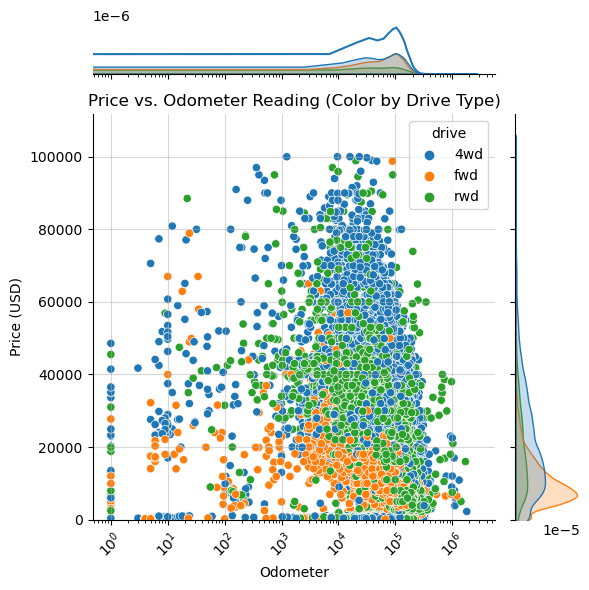

In [209]:

# Scatter plot with KDE for price and odometer (separate for clarity)
g = sns.jointplot(
    x="odometer",
    y="price",
    data=used_cars_data_filtered,
    hue="drive",
    kind="scatter",
)

# Add KDE plots to the margins
sns.kdeplot(used_cars_data_filtered["odometer"], ax=g.ax_marg_x)
# sns.kdeplot(used_cars_data_filtered["price"], ax=g.ax_marg_y)

# Customize the plot
plt.xscale("log")  # Log scale for odometer to better visualize spread
plt.xlabel("Odometer")

# Adjust y-axis (price) for readability
# Option 1: Set y-axis limits (assuming price range is known)
# plt.ylim(bottom=0, top=price_range_upper_limit)  # Replace with your price range

# Option 2: Enable grid lines for better estimation
plt.grid(True)

# Title and legend (optional adjustments)
plt.ylabel("Price (USD)")
txt= "Price vs. Odometer Reading (Color by Drive Type)"
plt.title(txt, fontsize=12)

# Truncate price axis to remove negative values (if not filtered earlier)
plt.ylim(bottom=0)  # Set minimum price to 0

# Increase legend font size (optional)
# plt.legend(title="Number of Cylinders", title_fontsize=10, labelfontsize=8)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Adjust grid line transparency
plt.grid(alpha=0.5)  # Adjust alpha value between 0 (invisible) and 1 (opaque)

plt.tight_layout()  # Improve spacing between elements
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)



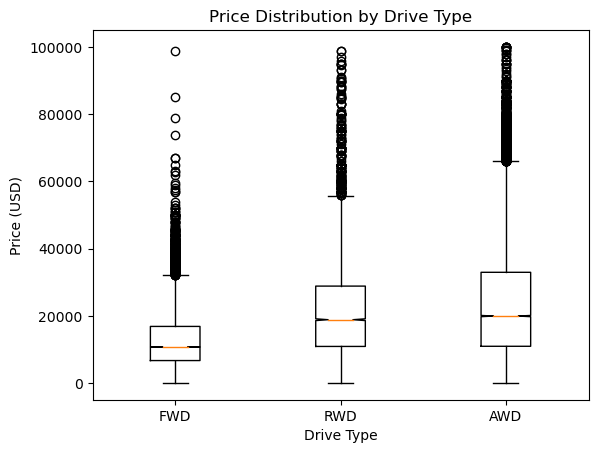

In [210]:

# Boxplot for price by drive type
plt.boxplot(
    [
        used_cars_data[used_cars_data["drive"] == "fwd"]["price"],
        used_cars_data[used_cars_data["drive"] == "rwd"]["price"],
        used_cars_data[used_cars_data["drive"] == "4wd"]["price"],
    ],
    labels=["FWD", "RWD", "AWD"],
    notch=True,
)
plt.xlabel("Drive Type")
plt.ylabel("Price (USD)")
txt="Price Distribution by Drive Type"
plt.title(txt)

file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)


Impact of Drive Type: The color gradient from blue (presumably front-wheel drive) to red (presumably all-wheel drive) suggests a possible trend. Cars with all-wheel drive tend to be priced higher on average, even at similar mileage, compared to front-wheel drive cars. Rear-wheel drive cars seem to fall somewhere in between.
Other factors like car model, brand, condition, and features can also influence price.

Price Distribution: The price distribution appears to be skewed towards lower prices. There might be a larger number of used cars concentrated in the lower price range.


,manufacturer,count
13,ford,70985
7,chevrolet,55064
39,toyota,34202
16,honda,21269
31,nissan,19067
20,jeep,19014
34,ram,18342
14,gmc,16785
4,bmw,14699
10,dodge,13707


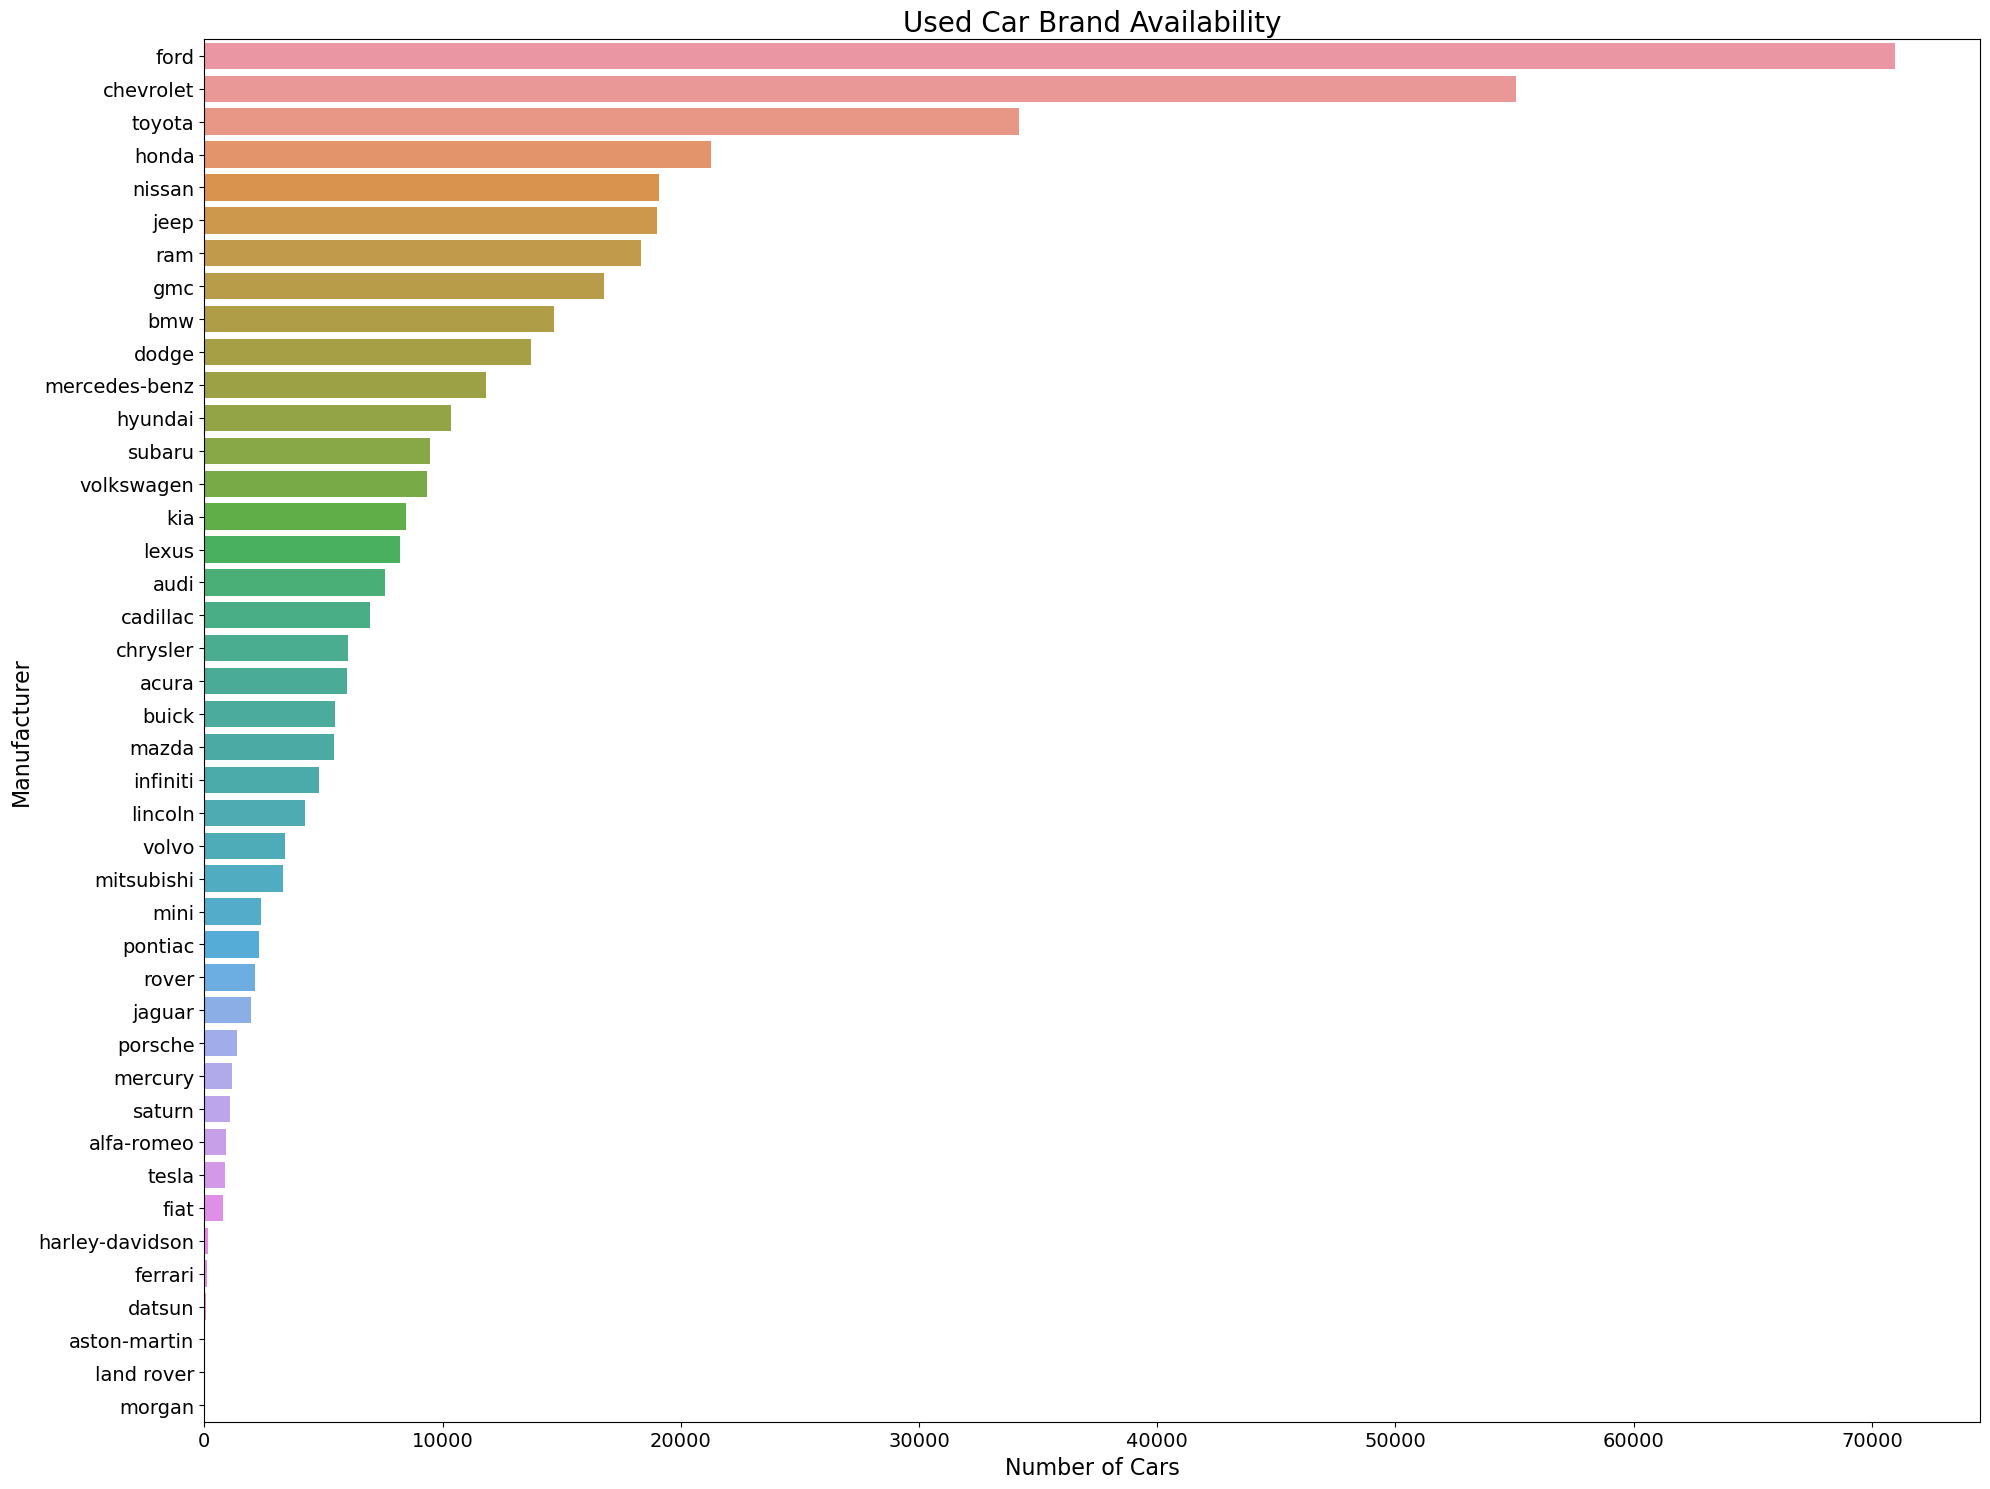

In [211]:
# Sort the DataFrame by manufacturer value counts in descending order
manufacturer_counts_sorted = cars['manufacturer'].value_counts().reset_index()
manufacturer_counts_sorted.columns = ['manufacturer', 'count']

txt="Used Car Brand Availability"
plt.figure(figsize=(20, 15))
sns.barplot(data=manufacturer_counts_sorted, y='manufacturer', x='count' )
plt.title(txt, fontsize=20)
plt.xlabel('Number of Cars', fontsize=16)  # Increased font size for x-label
plt.ylabel('Manufacturer', fontsize=16)     # Increased font size for y-label
plt.xticks(fontsize=14)  # Increased font size for x-axis tick values
plt.yticks(fontsize=14)  # Increased font size for y-axis tick values
plt.tight_layout()

#
plt.tight_layout()

# Save the plot as an image
# plt.savefig('Used_Car_Brand_Availability.png')
# plt.show()
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)


cars.groupby(['manufacturer']).size().reset_index(name='count').sort_values(by='count', ascending=False)

In [212]:
df['cylinders'].value_counts().sum()
print('Cylinder Categories are \n',df['cylinders'].value_counts())
print('\n Cylinder has 41% missing data, 1296 additional entries can be reassigned as Nan without impact to the data analysis')
print('Also converting Cylinder entries from categorical to numeric for data analysis')

df = df.replace({'8 cylinders':8, '6 cylinders':6, '4 cylinders':4, '5 cylinders':5,  \
                 '3 cylinders':3, '10 cylinders':10, '12 cylinders':12,'other':np.nan})
df.sample(5)


Cylinder Categories are 
 cylinders
4 cylinders     23007
6 cylinders     22197
8 cylinders     13480
5 cylinders       492
other             295
10 cylinders      213
3 cylinders       169
12 cylinders       34
Name: count, dtype: int64

 Cylinder has 41% missing data, 1296 additional entries can be reassigned as Nan without impact to the data analysis
Also converting Cylinder entries from categorical to numeric for data analysis


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
372904,el paso,10999,2019.0,buick,encore,excellent,4.0,gas,21930.0,rebuilt,automatic,KL4CJASBXKB761585,fwd,full-size,SUV,silver,tx
262524,las cruces,7000,2006.0,toyota,highlander,excellent,6.0,gas,108082.0,salvage,automatic,JTEDP21A460095117,fwd,NaN,SUV,red,nm
221874,springfield,7995,2012.0,chevrolet,cruze,NaN,4.0,gas,97592.0,clean,automatic,1G1PF5SC1C7287712,fwd,NaN,sedan,silver,mo
245686,lincoln,4250,2009.0,chevrolet,impala ls,excellent,6.0,gas,171147.0,clean,automatic,2G1WB57K391320707,fwd,full-size,sedan,NaN,ne
156622,des moines,12995,2014.0,ram,1500,excellent,6.0,gas,181170.0,clean,automatic,1C6RR6GG3ES188826,rwd,NaN,truck,NaN,ia


In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98508 entries, 2155 to 407603
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        98508 non-null  object 
 1   price         98508 non-null  int64  
 2   year          98508 non-null  float64
 3   manufacturer  96664 non-null  object 
 4   model         98506 non-null  object 
 5   condition     53813 non-null  object 
 6   cylinders     59592 non-null  float64
 7   fuel          92296 non-null  object 
 8   odometer      98508 non-null  float64
 9   title_status  95666 non-null  object 
 10  transmission  88290 non-null  object 
 11  VIN           98507 non-null  object 
 12  drive         76552 non-null  object 
 13  size          25236 non-null  object 
 14  type          80666 non-null  object 
 15  paint_color   74344 non-null  object 
 16  state         98508 non-null  object 
dtypes: float64(3), int64(1), object(13)
memory usage: 13.5+ MB


In [214]:
# List of categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Loop through each categorical column and count unique values
for col in categorical_cols:
    print("Column:", col)
    print(df[col].nunique())
    if df[col].nunique() < 15:
        print(f"Unique values: {df[col].unique()}")
    print()


Column: region
400

Column: manufacturer
40

Column: model
14243

Column: condition
6
Unique values: ['excellent' 'fair' 'good' 'like new' 'new' 'salvage' nan]

Column: fuel
4
Unique values: ['gas' 'electric' 'hybrid' 'diesel' nan]

Column: title_status
6
Unique values: ['clean' 'lien' 'missing' 'rebuilt' 'salvage' nan 'parts only']

Column: transmission
2
Unique values: ['manual' 'automatic' nan]

Column: VIN
98507

Column: drive
3
Unique values: ['4wd' 'fwd' 'rwd' nan]

Column: size
4
Unique values: ['compact' 'full-size' 'mid-size' 'sub-compact' nan]

Column: type
12
Unique values: ['SUV' 'convertible' 'coupe' 'hatchback' 'offroad' 'pickup' 'sedan'
 'truck' 'wagon' nan 'bus' 'mini-van' 'van']

Column: paint_color
12
Unique values: ['silver' 'brown' 'blue' 'white' 'black' 'grey' 'orange' 'red' nan
 'custom' 'green' 'purple' 'yellow']

Column: state
51



In [215]:
df.nunique().sort_values()

transmission        2
drive               3
size                4
fuel                4
condition           6
title_status        6
cylinders           7
type               12
paint_color        12
year               22
manufacturer       40
state              51
region            400
price           11465
model           14243
odometer        70347
VIN             98507
dtype: int64

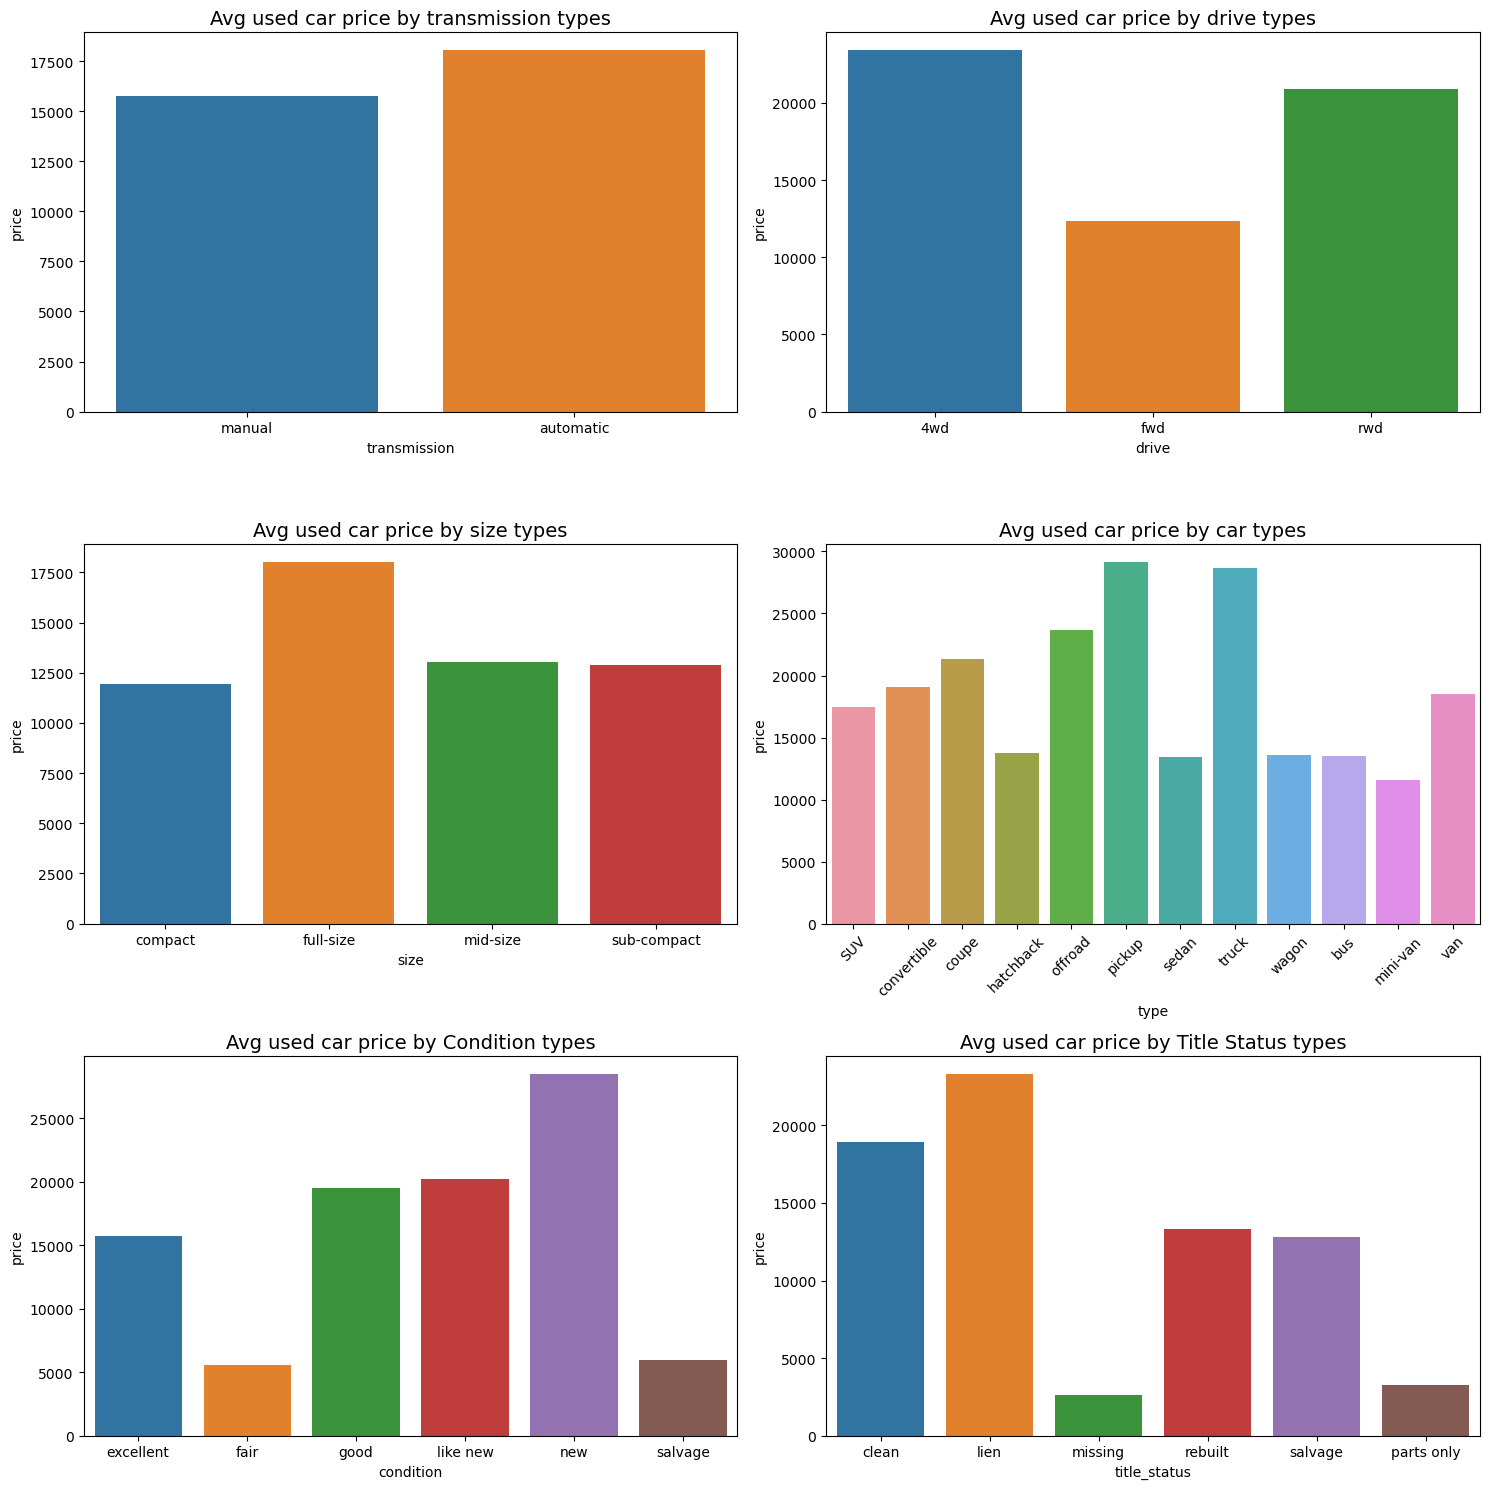

In [216]:

# Create a figure and subplots with 2 rows and 2 columns
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6) ) = plt.subplots(3, 2, figsize=(15, 15))

# Plot average used car price by transmission types
sns.barplot(data=df, x='transmission', y='price', estimator=np.mean, ci=None, ax=ax1)
ax1.set_title("Avg used car price by transmission types", fontsize=14)

# Plot average used car price by drive types
sns.barplot(data=df, x='drive', y='price', estimator=np.mean, ci=None, ax=ax2)
ax2.set_title("Avg used car price by drive types", fontsize=14)

# Plot average used car price by size types
sns.barplot(data=df, x='size', y='price', estimator=np.mean, ci=None, ax=ax3)
ax3.set_title("Avg used car price by size types", fontsize=14)

# Plot average used car price by car types
sns.barplot(data=df, x='type', y='price', estimator=np.mean, ci=None, ax=ax4)
ax4.set_title("Avg used car price by car types", fontsize=14)
# Rotate tick labels of the x-axis in the fourth subplot
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)


# Plot average used car price by size types
sns.barplot(data=df, x='condition', y='price', estimator=np.mean, ci=None, ax=ax5)
ax5.set_title("Avg used car price by Condition types", fontsize=14)

# Plot average used car price by car types
sns.barplot(data=df, x='title_status', y='price', estimator=np.mean, ci=None, ax=ax6)
ax6.set_title("Avg used car price by Title Status types", fontsize=14)

# Adjust layout
plt.tight_layout()

# Show plot

txt="Average Car Price for Various Categorical Attributes"
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)


### 2.3 Correlation plots 

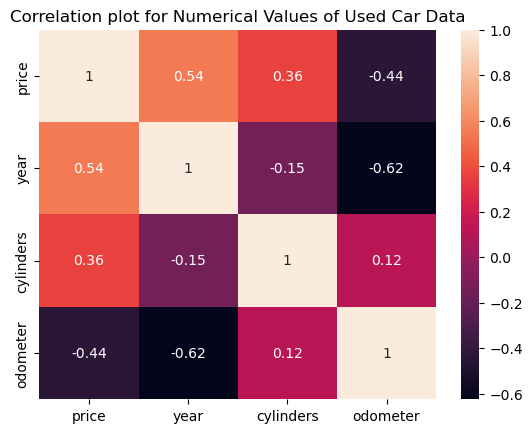

In [217]:
#  Correlation plots for exploratory data analysis 
corr = df.corr(numeric_only = True).round(3)
sns.heatmap(corr, annot = True);
txt="Correlation plot for Numerical Values of Used Car Data"
plt.title(txt)
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)


In [218]:
# this is exploratory purposes 

In [219]:
ohe_features = ['condition', 'transmission']
te_features = ['drive', 'type', 'state']
non_transformed_columns = ['year', 'odometer']

check_OHE = OneHotEncoder(sparse_output = False)
df_check_OHE = check_OHE.fit_transform(df[ohe_features])

check_TE = TargetEncoder()
df_check_TE = check_TE.fit_transform(df[['state', 'region']], df['price'])

df_check = pd.concat([pd.DataFrame(df_check_OHE, columns = check_OHE.get_feature_names_out()), df_check_TE, df[non_transformed_columns], df['price']],axis=1)

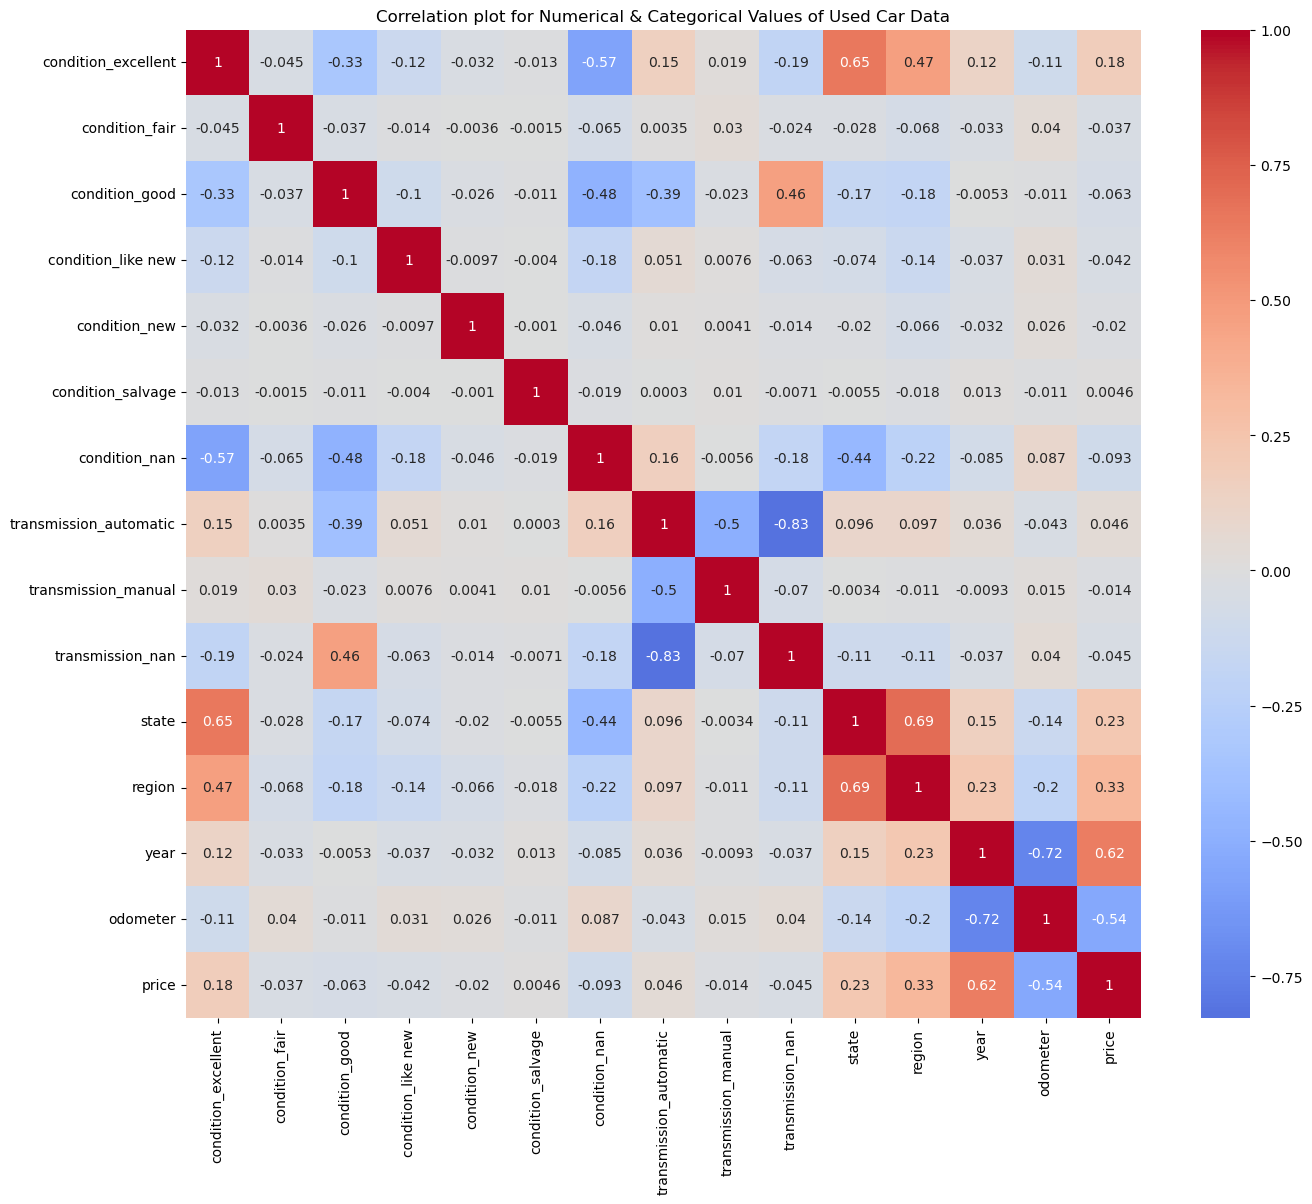

In [220]:
plt.figure(figsize = (14, 12))
sns.heatmap(df_check.corr(method = 'spearman'), annot=True, center = 0, cmap = 'coolwarm')
plt.tight_layout()

txt="Correlation plot for Numerical & Categorical Values of Used Car Data"
plt.title(txt)
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)

# Note: Actual One Hot encoding will be done during modeling/training. This is exploratory data analysis 



In [221]:
df_check.isna().sum()

condition_excellent       69900
condition_fair            69900
condition_good            69900
condition_like new        69900
condition_new             69900
condition_salvage         69900
condition_nan             69900
transmission_automatic    69900
transmission_manual       69900
transmission_nan          69900
state                     69900
region                    69900
year                      69900
odometer                  69900
price                     69900
dtype: int64

condition_excellent       0
condition_fair            0
condition_good            0
condition_like new        0
condition_new             0
condition_salvage         0
condition_nan             0
transmission_automatic    0
transmission_manual       0
transmission_nan          0
state                     0
region                    0
year                      0
odometer                  0
price                     0
dtype: int64

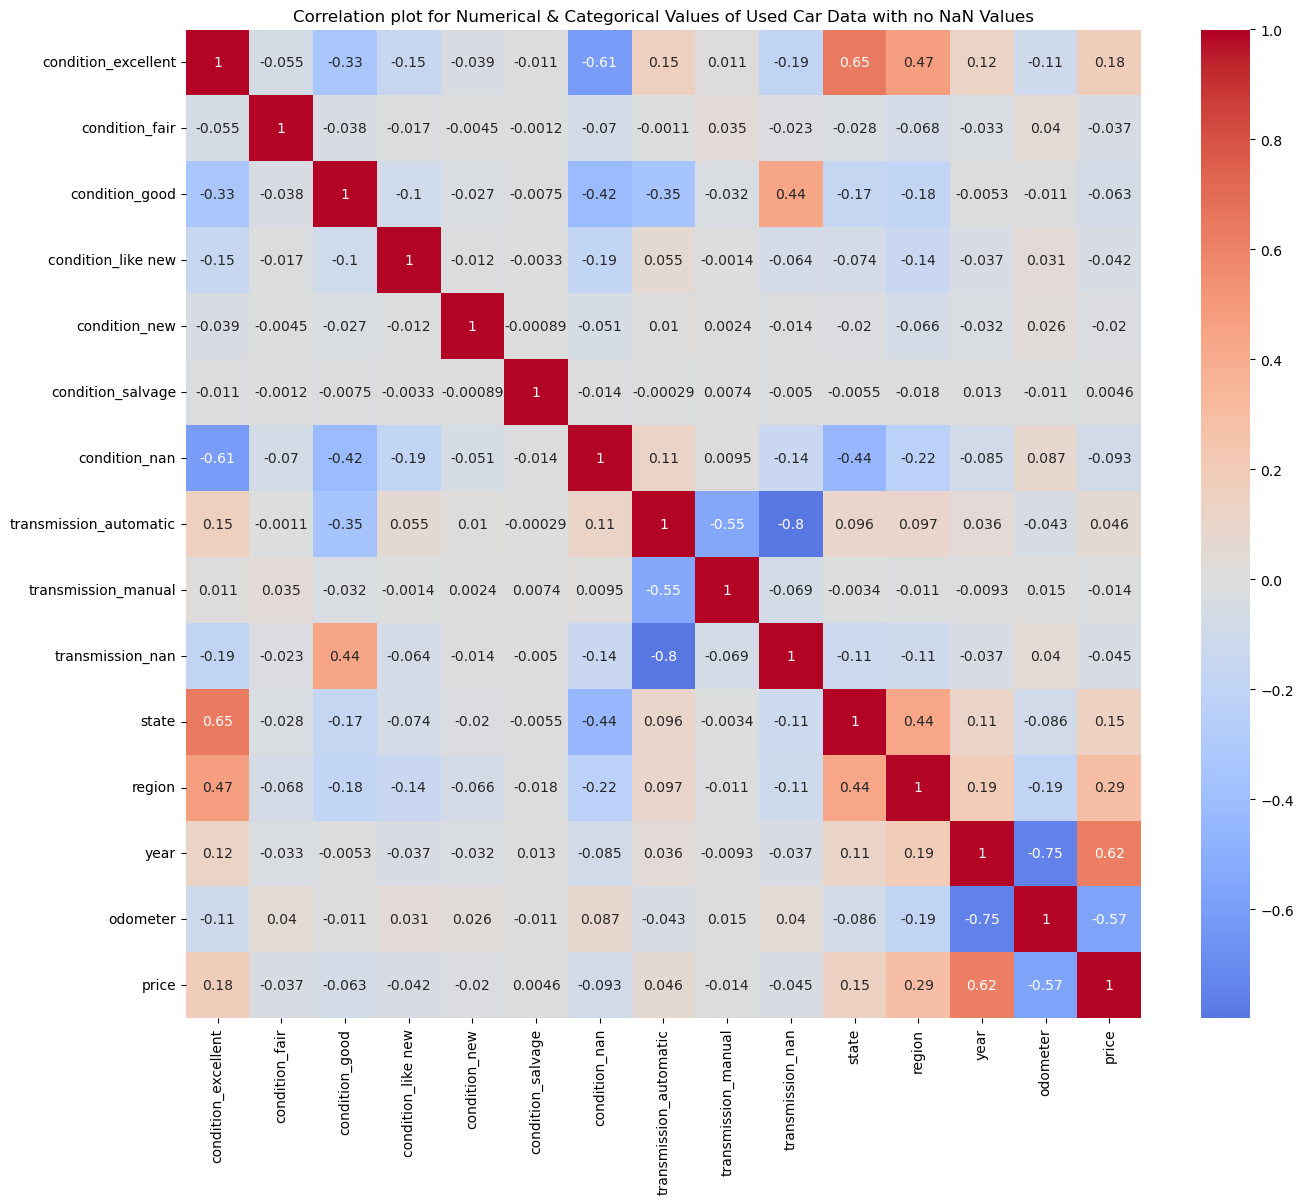

In [222]:
df_check2 = df_check.dropna()
plt.figure(figsize = (14, 12))
sns.heatmap(df_check2.corr(method = 'spearman'), annot=True, center = 0, cmap = 'coolwarm')
plt.tight_layout()

txt="Correlation plot for Numerical & Categorical Values of Used Car Data with no NaN Values"
plt.title(txt)
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)

# Note: Actual One Hot encoding will be done during modeling/training. This is exploratory data analysis 

df_check2.isna().sum()

### 3. Modeling

Downselect the dataset in hand to build some models.  Here, we build a number of different regression models with the price as the target.  We will explore different parameters and cross-validate our findings.

In [223]:
df = df.drop(['VIN','model','region'], axis =1).dropna()
len(df)

18995

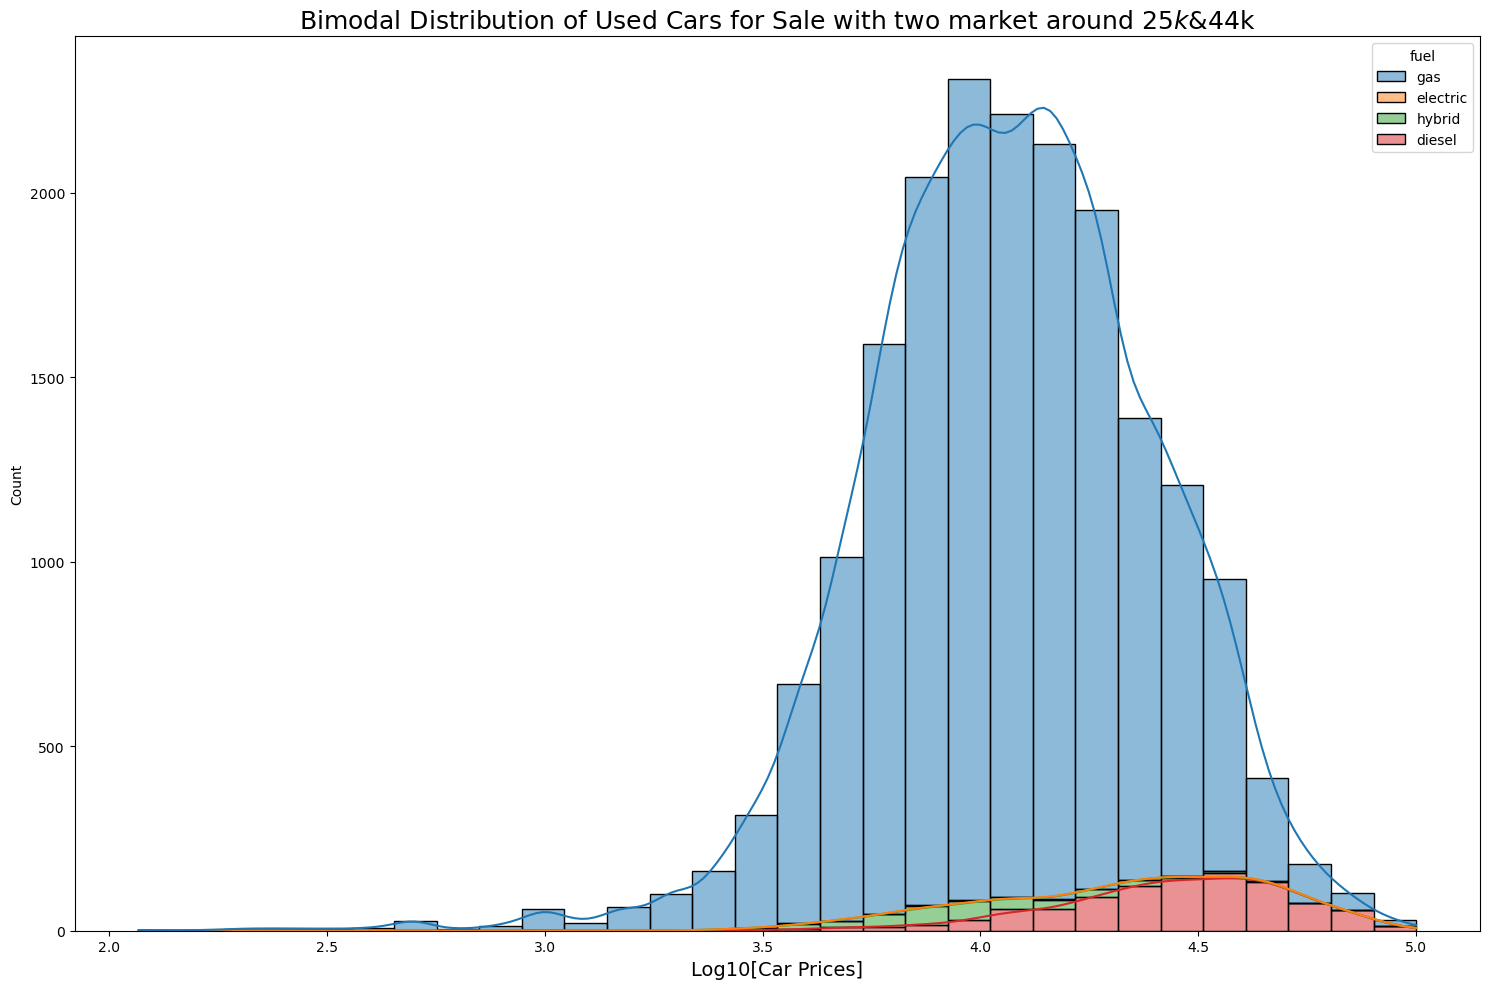

In [224]:
# Focus on premium cars: $30k - $50k range

valid_values = df['price'].dropna()
log_values = np.log10(valid_values + 1)  # Apply log10 transformation (adding 1 to avoid log(0))

plt.figure(figsize = (15,10))
txt ='Bimodal Distribution of Used Cars for Sale with two market around $25k & $44k'

sns.histplot(data=df, x=log_values, discrete=False,kde=True, bins =30, hue = 'fuel', multiple="stack")
plt.xlabel('Log10[Car Prices]', fontsize=14)  # Adding x-axis label
plt.title(txt, fontsize=18)  # Adding title
plt.tight_layout()
# plt.show()

###### 3.1 Using `SequentialFeatureSelector`

Now, using the polynomial features use forward feature selection to select three features (`n_features_to_select = 3`) using a `LinearRegression` estimator to perform the feature selection on the training data.  Assign the transformed features to `best_features_df` as a DataFrame with appropriate feature names.  The transformer should be instantiated as `selector` and the transformed training data should be assigned to `best_features` as an array. 

In [225]:

X = df.drop(['price'],axis=1)
# y = df[['price']]
y = np.log1p(df.price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # get training dataset (60% of data)
print(("Training set size:", X_train.shape, y_train.shape))
print(("Test set size:", X_test.shape, y_test.shape))

('Training set size:', (15196, 13), (15196,))
('Test set size:', (3799, 13), (3799,))


In [226]:
#build polynomial features 

In [227]:
from sklearn.preprocessing import PolynomialFeatures

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

poly_features = PolynomialFeatures(degree = 3, include_bias=False)
#select numeric data for fitting

X_train_poly = poly_features.fit_transform(X_train.select_dtypes(include=numerics))
X_test_poly = poly_features.fit_transform(X_test.select_dtypes(include=numerics))

#get names of all the newly created columns 
columns = poly_features.get_feature_names_out()

train_df = pd.DataFrame(X_train_poly, columns=columns)
test_df = pd.DataFrame(X_test_poly, columns = columns)


train_df.head()

,year,cylinders,odometer,year^2,year cylinders,year odometer,cylinders^2,cylinders odometer,odometer^2,year^3,year^2 cylinders,year^2 odometer,year cylinders^2,year cylinders odometer,year odometer^2,cylinders^3,cylinders^2 odometer,cylinders odometer^2,odometer^3
0,2012.0,8.0,44430.0,4048144.0,16096.0,89393160.0,64.0,355440.0,1.974025e+09,8.144866e+09,32385152.0,1.798590e+11,128768.0,7.151453e+08,3.971738e+12,512.0,2843520.0,1.579220e+10,8.770593e+13
1,2014.0,4.0,87399.0,4056196.0,8056.0,176021586.0,16.0,349596.0,7.638585e+09,8.169179e+09,16224784.0,3.545075e+11,32224.0,7.040863e+08,1.538411e+13,64.0,1398384.0,3.055434e+10,6.676047e+14
2,2018.0,4.0,95895.0,4072324.0,8072.0,193516110.0,16.0,383580.0,9.195851e+09,8.217950e+09,16289296.0,3.905155e+11,32288.0,7.740644e+08,1.855723e+13,64.0,1534320.0,3.678340e+10,8.818361e+14
3,2006.0,6.0,199200.0,4024036.0,12036.0,399595200.0,36.0,1195200.0,3.968064e+10,8.072216e+09,24144216.0,8.015880e+11,72216.0,2.397571e+09,7.959936e+13,216.0,7171200.0,2.380838e+11,7.904383e+15
4,2008.0,8.0,171611.0,4032064.0,16064.0,344594888.0,64.0,1372888.0,2.945034e+10,8.096385e+09,32256512.0,6.919465e+11,128512.0,2.756759e+09,5.913627e+13,512.0,10983104.0,2.356027e+11,5.054001e+15


In [228]:
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3)
best_features = selector.fit_transform(train_df, y_train)
best_features_df = pd.DataFrame(best_features, columns = selector.get_feature_names_out())
best_features_df.head()

,cylinders,year^3,year^2 odometer
0,8.0,8.144866e+09,1.798590e+11
1,4.0,8.169179e+09,3.545075e+11
2,4.0,8.217950e+09,3.905155e+11
3,6.0,8.072216e+09,8.015880e+11
4,8.0,8.096385e+09,6.919465e+11


Now, create a Pipeline object with steps column_selector to select three features, and linreg to build a LinearRegression estimator. Determine the Mean Squared Error on the train and test set respectively and assign to train_mse and test_mse as a float. Be sure to use train_df and test_df from above for fitting and predicting.

In [229]:
pipe = Pipeline([('column_selector', selector),
                ('linreg', LinearRegression())])
pipe.fit(train_df, y_train)
train_preds = pipe.predict(train_df)
test_preds  = pipe.predict(test_df)
train_mse   = mean_squared_error(y_train, train_preds)
test_mse    = mean_squared_error(y_test, test_preds)
train_r2    = 100*r2_score(y_train, train_preds).round(3) 
test_r2     = 100*r2_score(y_test, test_preds).round(3) 

# check
print(f'Sequential Feature Selection Train MSE: {train_mse: .2f}')
print(f'Sequential Feature Selection Test MSE: {test_mse: .2f}')
print(f'Sequential Feature Selection Train R^2: {train_r2: .2f}')
print(f'Sequential Feature Selection Test R^2: {test_r2: .2f}')
pipe

Sequential Feature Selection Train MSE:  0.23
Sequential Feature Selection Test MSE:  0.23
Sequential Feature Selection Train R^2:  59.50
Sequential Feature Selection Test R^2:  60.20


Pipeline(steps=[('column_selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=3)),
                ('linreg', LinearRegression())])

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**
**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

### 3.2 Cross-Validation with `SequentialFeatureSelector`
Use the `shuffle` and `np.split` functions to create the train/test split indices. 
Then, these indices are passed to the 'cv' argument in the `SequentialFeatureSelector`. Here, rather than using a Pipeline we conduct the transformations by hand, and feed the resulting selected features into a `LinearRegression` estimator.

In [230]:
from random import shuffle, seed
all_indices = list(range(0, len(df)))
seed(42)
shuffle(all_indices)
# all_indices[:5]

#### Split indices to train and test values

Use the `np.split` function to split the data based on the first 80% of the values of `all_indices`.  Assign these as arrays to `train_idx` and `test_idx` below.  

In [231]:
all_indices = list(range(0, len(df)))
seed(42)
shuffle(all_indices)
train_idx, test_idx = np.split(all_indices, [int(0.8*len(df))])


In [232]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = df.select_dtypes(include=numerics).drop('price', axis = 1) 
y = np.log1p(df.price)

# n_features_to_select=2, because n_features_to_select must be < n_features.
selector = SequentialFeatureSelector(estimator=LinearRegression(),
                                    n_features_to_select=2,  
                                    cv = [[train_idx, test_idx]],
                                    scoring = 'neg_mean_squared_error')
Xt = selector.fit_transform(X, y)
print(Xt.shape) #should have colum = n_features_to_select



(18995, 2)


In [233]:
lr = LinearRegression().fit(Xt, y)
model_preds = lr.predict(Xt)
mse = mean_squared_error(y, model_preds).round(2)
r2     = 100*r2_score(y, model_preds).round(3) 

print("MSE with Cross-Validation with SequentialFeatureSelector =",mse)
print("R^2 with Cross-Validation with SequentialFeatureSelector =",r2,'%')


MSE with Cross-Validation with SequentialFeatureSelector = 0.25
R^2 with Cross-Validation with SequentialFeatureSelector = 56.2 %


#### Creating `SequentialFeatureSelector` object
Create a `SequentialFeatureSelector` object named `selector` below that:

- Uses `LinearRegression` estimator to select features
- Select 3 features using `n_features_to_select`
- Use `train_idx` and `test_idx` in the `cv` argument
- Use `neg_mean_squared_error` as the scorer 

Use the selector to transform the data `X` given below (you'll also need `y`).  
Assign the transformed data as an array to `Xt` below.

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**
**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

### 3.3 Ridge regression model and its alpha parameter.

In [234]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis = 1), np.log1p(df.price), 
                                                   random_state=42, test_size = 0.2)
# Check
# print(X_train.shape)
# print(X_test.shape)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
poly_features = PolynomialFeatures(degree = 3, include_bias=False)
#select numeric data for fitting

X_train_poly = poly_features.fit_transform(X_train.select_dtypes(include=numerics))
X_test_poly = poly_features.fit_transform(X_test.select_dtypes(include=numerics))

#get names of all the newly created columns 
columns = poly_features.get_feature_names_out()
train_df = pd.DataFrame(X_train_poly, columns=columns)
test_df = pd.DataFrame(X_test_poly, columns = columns)
# train_df.head()



In [235]:

X_train = train_df 
X_test = test_df 
y_train = y_train
y_test = y_test

model_1 = Ridge().fit(X_train.select_dtypes(include=numerics), y_train)
model_1_coefs = model_1.coef_

print(f'Ridge Coefs: {np.round(model_1_coefs, 3)}')
print('coefficients equate to the number of numeric coloums based on SFE')
# print(X_train.shape)
# print(X_train.select_dtypes(include=numerics).shape)
 

Ridge Coefs: [-2.000e-03  1.000e-03  6.700e-02 -0.000e+00 -8.000e-03 -0.000e+00
  1.772e+00 -0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
 -1.000e-03  0.000e+00 -0.000e+00 -8.000e-03  0.000e+00  0.000e+00
 -0.000e+00]
coefficients equate to the number of numeric coloums based on SFE


In [236]:
alphas = [0.001, 1.0, 10.0, 100.0]
coef_list = []
 
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_train, y_train)
    coef_list.append(list(ridge.coef_))
    

# check
print('Ensure coeff. col are same as len of alpha array =',len(coef_list),'\n')
print('For alpha = 100 we have the following coefficients:')
list(zip(X_train.columns, coef_list[-1]))

Ensure coeff. col are same as len of alpha array = 4 

For alpha = 100 we have the following coefficients:


[('year', -2.0407929436920608e-05),
 ('cylinders', 1.385582668420995e-05),
 ('odometer', 0.06337256842482814),
 ('year^2', -0.0003847552698874022),
 ('year cylinders', 0.0024930632521173186),
 ('year odometer', -6.294056834926425e-05),
 ('cylinders^2', 0.022831548299988697),
 ('cylinders odometer', -8.996926065385872e-05),
 ('odometer^2', 1.0045164454421341e-10),
 ('year^3', 1.3481731831396536e-07),
 ('year^2 cylinders', -1.3620046224259132e-06),
 ('year^2 odometer', 1.56272089741482e-08),
 ('year cylinders^2', 5.463403379075379e-05),
 ('year cylinders odometer', 4.412417271389264e-08),
 ('year odometer^2', -4.4861802927924854e-14),
 ('cylinders^3', -0.007829940245957342),
 ('cylinders^2 odometer', 1.004097630649519e-07),
 ('cylinders odometer^2', 1.6919331815194442e-14),
 ('odometer^3', -4.391713482992654e-18)]

In [237]:
pd.DataFrame(coef_list).transpose().set_index(X_train.columns)

,0,1,2,3
year,-1.858511e+00,-1.896145e-03,-1.917382e-04,-2.040793e-05
cylinders,7.047751e-01,1.027096e-03,1.133524e-04,1.385583e-05
odometer,6.695986e-02,6.716133e-02,6.684734e-02,6.337257e-02
year^2,6.190083e-04,-2.912767e-04,-2.976398e-04,-3.847553e-04
year cylinders,-4.520560e-02,-7.997060e-03,1.346919e-03,2.493063e-03
year odometer,-6.648286e-05,-6.670035e-05,-6.639275e-05,-6.294057e-05
cylinders^2,7.822156e+00,1.771709e+00,2.223526e-01,2.283155e-02
cylinders odometer,-9.873656e-05,-9.274795e-05,-9.112066e-05,-8.996926e-05
odometer^2,1.315223e-10,1.002237e-10,9.307907e-11,1.004516e-10
year^3,-5.551773e-08,1.016002e-07,1.057114e-07,1.348173e-07


Note: In general, as you increase `alpha` the value of the coefficient `decreases` 

In [238]:
# scaled_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())]).fit(X_train, y_train)
# train_preds = scaled_pipe.predict(X_train)
# test_preds  = scaled_pipe.predict(X_test)
train_mse   = mean_squared_error(y_train, train_preds).round(3) 
test_mse    = mean_squared_error(y_test, test_preds).round(3) 
train_r2    = 100*r2_score(y_train, train_preds).round(3) 
test_r2     = 100*r2_score(y_test, test_preds).round(3) 

# Print Results
print(f'Ridge with 3 deg polynomial Train MSE: {train_mse}')
print(f'Ridge with 3 deg polynomial Test MSE: {test_mse}')
print(f'Ridge with 3 deg polynomial Train R^2: {test_r2}%')
print(f'Ridge with 3 deg polynomial Test R^2: {test_r2}%')

Ridge with 3 deg polynomial Train MSE: 0.229
Ridge with 3 deg polynomial Test MSE: 0.226
Ridge with 3 deg polynomial Train R^2: 60.199999999999996%
Ridge with 3 deg polynomial Test R^2: 60.199999999999996%


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**
**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

### 3.3 Creating a Ridge Pipeline with  `StandardScaler`
Use `StandardScaler` for scaling the data by converting it to $z$-scores.  
To begin, you will scale data using just `numpy` functions.  Then, you will use the scikitlearn transformer and incorporate it into a `Pipeline` with a `Ridge` regression model.  

In [239]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = df.select_dtypes(include=numerics).drop('price', axis = 1) 
y = np.log1p(df.price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


# Recall that **standard scaling** consists of subtracting the feature mean from each datapoint 
# and subsequently dividing by the standard deviation of the feature.  
# Below, you are to scale `X_train` by subtracting the mean and dividing by the standard deviation.  
# Be sure to use the `numpy` mean and standard deviation functions with default settings.  
# Assign your results to `X_train_scaled` below.  
X_train_scaled = (X_train - np.mean(X_train))/np.std(X_train)
X_test_scaled = (X_test - np.mean(X_train))/np.std(X_train)
# To scale the test data, use the mean and standard deviation of the **training** data. 
# In practice, you would not have seen the test data, so you would not be able to compute its mean and deviation.  
# Instead, you assume it is similar to your train data and use what you know to scale it. 


Using StandardScaler
To use the StandardScaler transformer do the following:
Instantiate as scaler below.
Use the .fit_transform method to transform the training data
Use the .transform method to transform the test data

In [240]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Building a `Pipeline` #### 
Now, construct a pipeline with named steps `scaler` and `ridge` that takes in your data, applies the `StandardScaler` and fits a `Ridge` model with default settings. Assign your pipeline to `scaled_pipe` and compute the mean squared error for both the train and test data, assign to `train_mse` and `test_mse` respectively.

In [241]:
scaled_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())]).fit(X_train, y_train)
train_preds = scaled_pipe.predict(X_train)
test_preds  = scaled_pipe.predict(X_test)
train_mse   = mean_squared_error(y_train, train_preds).round(3) 
test_mse    = mean_squared_error(y_test, test_preds).round(3) 
train_r2    = 100*r2_score(y_train, train_preds).round(3) 
test_r2     = 100*r2_score(y_test, test_preds).round(3) 

# Print Results
print(f'Ridge Train MSE: {train_mse}')
print(f'Ridge Test MSE: {test_mse}')
print(f'Ridge Train R^2: {test_r2}%')
print(f'Ridge Test R^2: {test_r2}%')

Ridge Train MSE: 0.229
Ridge Test MSE: 0.226
Ridge Train R^2: 60.199999999999996%
Ridge Test R^2: 60.199999999999996%


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**
**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

### 3.4 Using `GridSearchCV`

This activity focuses on using `GridSearchCV` to search over different hyperparameter values within the `Ridge` estimator.  You will first use the grid search to search parameters for an estimator.  Then, you will incorporate a pipeline into the grid search and identify the step in the pipeline you are searching along with the hyperparameters. 

In [242]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = df.select_dtypes(include=numerics).drop('price', axis = 1) 
y = np.log1p(df.price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train_scaled = (X_train - np.mean(X_train))/np.std(X_train)
X_test_scaled = (X_test - np.mean(X_train))/np.std(X_train)
 

#### 1. Dictionary for grid search
To search over hyperparameters you have to create a dictionary with a key whose name is exactly that of the hyperparameter to search over.  With the `Ridge` estimator, this will be `alpha`.  Create a dictionary with `alpha` as the key and values `[0.1, 1.0, 10.0]` and assign to the variable `params_dict` below.  

In [243]:
params_dict = {'alpha': [0.1, 1.0, 10.0]}

#### 2. Creating the grid search object
The `GridSearchCV` object takes in two elements -- an estimator and a dictionary of values to search over.  Below, instantiate a grid search object using your `params_dict` from problem 1 with a `Ridge` estimator.  Assign your estimator to `ridge` and your grid to `grid` below. 

In [244]:
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=params_dict)
#Check
print(grid.get_params()['param_grid'])
print(grid)

{'alpha': [0.1, 1.0, 10.0]}
GridSearchCV(estimator=Ridge(), param_grid={'alpha': [0.1, 1.0, 10.0]})


#### 3. Performing the grid search
Use your `grid` object above to fit the estimator to the training data.  Make predictions on the training and test data and use these predictions to determine the mean squared error on the train and test data.  Assign these to `train_mse` and `test_mse` respectively. 

In [245]:
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=params_dict)
grid.fit(X_train, y_train)
train_preds = grid.predict(X_train)
test_preds = grid.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds).round(2)
test_mse = mean_squared_error(y_test, test_preds).round(2)
train_r2    = 100*r2_score(y_train, train_preds).round(3) 
test_r2     = 100*r2_score(y_test, test_preds).round(3) 

print(f'Ridge with Grid CV Train MSE: {train_mse}')
print(f'Ridge with Grid CV Test MSE: {test_mse}')
print(f'Ridge with Grid CV Train R^2: {train_r2: .2f}')
print(f'Ridge with Grid CV  Test R^2: {test_r2: .2f}')


Ridge with Grid CV Train MSE: 0.23
Ridge with Grid CV Test MSE: 0.23
Ridge with Grid CV Train R^2:  59.80
Ridge with Grid CV  Test R^2:  59.30


#### 4. Identify optimal alpha value
Use your fit grid to determine the optimal alpha value.  Assign this as a float to `best_alpha` below.  (**Hint**: Use the `best_params_` attribute of the fit grid.)

In [246]:
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=params_dict)
grid.fit(X_train, y_train)
best_alpha = grid.best_params_
# Answer check
print(f'Best alpha: {list(best_alpha.values())[0]}')

Best alpha: 10.0


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**
**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**
### 3.5 LASSO and Sequential Feature Selection
Compares Lasso a regularized regression method with that of sequential feature selection.   Rather than using the LASSO as a model,  compare it to the `SequentialFeatureSelection` transformer as a method to select important features for a regression model. 

Say we build a polynomial model of degree 3 to compare the results of a Lasso and that of a LinearRegression model. Finally, use the Lasso estimator to select features in a pipeline with SelectFromModel.

In [247]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = df.select_dtypes(include=numerics).drop('price', axis = 1) 
y = np.log1p(df.price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


To start, build a `Pipeline` named `wage_pipe` with named steps `polyfeatures`, `scaler` and `lasso` model that utilize `PolynomialFeatures`, `StandardScaler`, and the `Lasso` estimator with the following parameters:

- `degree = 3` in `PolynomialFeatures`
- `include_bias = False` in `PolynomialFeatures`
- `random_state = 42` in `Lasso`

Fit the pipeline on `X_train` and `y_train` data given.  Extract the lasso coefficients from the pipeline and assign them as an array to `lasso_coefs` below.  
 

In [248]:
price_pipe = Pipeline([('polyfeatures', PolynomialFeatures(degree = 3, include_bias = False)),
                      ('scaler', StandardScaler()),
                     ('lasso', Lasso(random_state = 42))])
price_pipe.fit(X_train, y_train)
lasso_coefs = price_pipe.named_steps['lasso'].coef_


# Answer check
print(type(lasso_coefs))
print(lasso_coefs)
price_pipe

<class 'numpy.ndarray'>
[ 0.  0. -0.  0.  0. -0.  0. -0. -0.  0.  0. -0.  0. -0. -0.  0. -0. -0.
 -0.]


Pipeline(steps=[('polyfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()),
                ('lasso', Lasso(random_state=42))])

In [249]:
lasso_train_mse = mean_squared_error(y_train, price_pipe.predict(X_train))
lasso_test_mse  = mean_squared_error(y_test, price_pipe.predict(X_test))
lasso_r2        = r2_score(y_train, price_pipe.predict(X_train)).round(3) 
lasso_r2        = r2_score(y_test, price_pipe.predict(X_test)).round(3) 


# Answer check
print(f'Lasso Train MSE = {lasso_train_mse}')
print(f'Lasso Test MSE  = {lasso_test_mse}')
print(f'Lasso Train R^2: {test_r2}%')
print(f'Lasso Test R^2: {test_r2}%')

Lasso Train MSE = 0.5617159836858495
Lasso Test MSE  = 0.5764302202877951
Lasso Train R^2: 59.3%
Lasso Test R^2: 59.3%


#### Comparing `Lasso` to `SequentialFeatureSelection`
As seen above, the Lasso model effectively eliminated all features from the cubic polynomial example.  
Now, you are to build a `Pipeline` object called `sequential_pipe` with named steps `poly_features`, `selector`, and `linreg` with `PolynomialFeatures`, `SequentialFeatureSelector`, and `LinearRegression` respectively that uses the folowing parameters:

- `degree = 3` in `PolynomialFeatures` step `poly_features`
- `include_bias = False` in `PolynomialFeatures` step `poly_features`
- `n_features_to_select = 6` in `selector`



Note that you are to use the `LinearRegression` estimator as your estimator in the `SequentialFeatureSelector`. 

In [250]:
sequential_pipe = Pipeline([('poly_features', PolynomialFeatures(degree = 3, include_bias = False)),
                           ('selector', SequentialFeatureSelector(LinearRegression(), 
                                                                  n_features_to_select=6)),
                           ('linreg', LinearRegression())])
sequential_pipe.fit(X_train, y_train)
sequential_train_mse = mean_squared_error(y_train, sequential_pipe.predict(X_train)).round(2)
sequential_test_mse = mean_squared_error(y_test, sequential_pipe.predict(X_test)).round(2)
sequential_train_r2        = r2_score(y_train, sequential_pipe.predict(X_train)).round(3) 
sequential_test_r2        = r2_score(y_test, sequential_pipe.predict(X_test)).round(3) 


# Answer check
print(f'Lasso with Sequential Train MSE = {lasso_train_mse}')
print(f'Lasso with Sequential Test MSE  = {lasso_test_mse}')
print(f'Lasso with Sequential Train R^2: {test_r2}%')
print(f'Lasso with Sequential Test R^2: {test_r2}%')

Lasso with Sequential Train MSE = 0.5617159836858495
Lasso with Sequential Test MSE  = 0.5764302202877951
Lasso with Sequential Train R^2: 59.3%
Lasso with Sequential Test R^2: 59.3%


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**
**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

5. Using Lasso as a feature selector
Rather than using the Lasso as the estimator, you can use the results of the Lasso to select features that are subsequently used in a LinearRegression estimator. To do so, scikitlearn provides a function in the feature_selection module called SelectFromModel that will select the features based on coefficients.
As such, using the Lasso estimator to select features would involve instantiating the SelectFromModel transformer and selecting features as:
selector = SelectFromModel(Lasso())
selector.transform(X_train)
From here, the selector can be used in a Pipeline after transforming the features and before building a regression model. Such a pipeline is given below and you are to use this to fit on the training data and score on the testing data. Which model performs better, the model with sequential feature selection or that using the Lasso to select the features?
Assign your train and test error using the model_selector_pipe as selector_train_mse and selector_test_mse below.
For more information and examples on SelectFromModel.

In [251]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
model_selector_pipe = Pipeline([('poly_features', PolynomialFeatures(degree = 3, include_bias = False)),
                                ('scaler', StandardScaler()),
                                ('selector', SelectFromModel(Lasso())),
                                ('linreg', LinearRegression())])

In [252]:
model_selector_pipe 

Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()),
                ('selector', SelectFromModel(estimator=Lasso())),
                ('linreg', LinearRegression())])

In [253]:
clf = LinearRegression().fit(X, y)
result = permutation_importance(clf, X, y, n_repeats=10, random_state=0)
print("Length of results is same a num of col in X =",len(result)) 
print(result)

Length of results is same a num of col in X = 3
{'importances_mean': array([0.66761343, 0.41411365, 0.09547135]), 'importances_std': array([0.00583561, 0.00569268, 0.00137363]), 'importances': array([[0.67308221, 0.67087947, 0.65798349, 0.65914442, 0.66468164,
        0.6653352 , 0.66601468, 0.67743339, 0.66965949, 0.6719203 ],
       [0.41677466, 0.40962298, 0.41475409, 0.41328556, 0.41649202,
        0.4099451 , 0.42118376, 0.40098307, 0.41815239, 0.41994288],
       [0.0933548 , 0.09674515, 0.09500476, 0.09516403, 0.09479405,
        0.09668506, 0.09552633, 0.09841281, 0.09438819, 0.09463835]])}


In [254]:
for i in result.importances_mean.argsort()[::-1]:
  if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
    print(f"{X.columns[i]:<8}: "
          f"{result.importances_mean[i]:.3f}"
          f" +/- {result.importances_std[i]:.3f}")

year    : 0.668 +/- 0.006
cylinders: 0.414 +/- 0.006
odometer: 0.095 +/- 0.001


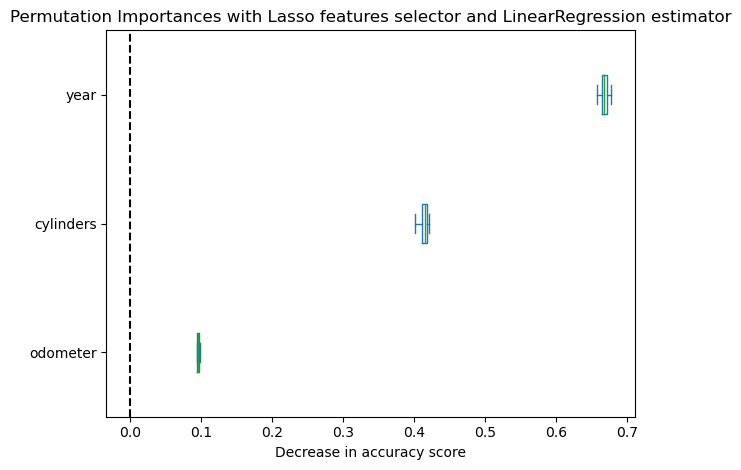

In [255]:
sorted_importances_idx = result.importances_mean.argsort()

# convert col. to numpy array
tt = pd.DataFrame(X.columns[sorted_importances_idx])
tt= tt.set_index(0).index.to_numpy()

importances = pd.DataFrame(result.importances[sorted_importances_idx].T,
                           columns=tt)

ax = importances.plot.box(vert=False, whis=10)
txt="Permutation Importances with Lasso features selector and LinearRegression estimator"
ax.set_title(txt)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)

In [256]:
# One hot encoding and elaborate analysis for prediction 

In [257]:
df = df.dropna()
df.sample(3)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
347265,5332,2003.0,chevrolet,good,8.0,gas,247296.0,clean,automatic,rwd,full-size,SUV,red,sc
403575,5000,2005.0,subaru,good,4.0,gas,245000.0,clean,manual,4wd,mid-size,wagon,red,wa
66895,5950,2005.0,honda,excellent,6.0,gas,155000.0,clean,automatic,rwd,mid-size,SUV,silver,ca


In [258]:
df.shape
df.isna().mean()

price           0.0
year            0.0
manufacturer    0.0
condition       0.0
cylinders       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
size            0.0
type            0.0
paint_color     0.0
state           0.0
dtype: float64

In [259]:
std_columns = ['year', 'odometer', 'cylinders']
data_std = pd.DataFrame(StandardScaler().fit_transform(df[std_columns]), columns = std_columns)
categorical_features = ['manufacturer','condition','fuel','title_status','transmission','drive','size','type','paint_color']
data_std = pd.concat([data_std, df[categorical_features + ['price']]], axis=1)
data_std = data_std.dropna()
data_std.head()

,year,odometer,cylinders,manufacturer,condition,fuel,title_status,transmission,drive,size,type,paint_color,price
215,-0.119628,-0.393647,0.162695,toyota,excellent,gas,clean,automatic,fwd,compact,sedan,blue,4000.0
268,1.400766,-1.202469,0.162695,mazda,excellent,gas,clean,automatic,rwd,compact,convertible,white,9000.0
346,-1.422823,0.239248,1.409830,ferrari,good,gas,clean,automatic,rwd,mid-size,convertible,red,98900.0
355,0.749168,-0.726248,0.162695,mercedes-benz,good,gas,clean,automatic,rwd,full-size,sedan,silver,9400.0
364,-0.771226,0.286668,1.409830,lexus,good,gas,clean,automatic,fwd,mid-size,SUV,white,7300.0


In [260]:
# more elaborate analysis using One Hot encoder

In [261]:
# Get the number of rows
num_rows = data_std.shape[0]

# Calculate the split index
split_index = int(num_rows * 0.8)

# Split the DataFrame into training and testing sets
# np.random.seed(42)
# data_train, data_test = np.split(shuffle(data_std), [int(num_rows*.7)], axis=0)

data_train = data_std.iloc[:split_index]
data_test = data_std.iloc[split_index:]
X_train, y_train = data_train.drop('price', axis=1), data_train['price']
X_test, y_test   = data_test.drop('price', axis=1), data_test['price']

print(X_train.columns == X_test.columns)
print(y_train[:5])
X_train.head()

[ True  True  True  True  True  True  True  True  True  True  True  True]
215     4000.0
268     9000.0
346    98900.0
355     9400.0
364     7300.0
Name: price, dtype: float64


,year,odometer,cylinders,manufacturer,condition,fuel,title_status,transmission,drive,size,type,paint_color
215,-0.119628,-0.393647,0.162695,toyota,excellent,gas,clean,automatic,fwd,compact,sedan,blue
268,1.400766,-1.202469,0.162695,mazda,excellent,gas,clean,automatic,rwd,compact,convertible,white
346,-1.422823,0.239248,1.409830,ferrari,good,gas,clean,automatic,rwd,mid-size,convertible,red
355,0.749168,-0.726248,0.162695,mercedes-benz,good,gas,clean,automatic,rwd,full-size,sedan,silver
364,-0.771226,0.286668,1.409830,lexus,good,gas,clean,automatic,fwd,mid-size,SUV,white


In [262]:
# te_features = ['drive', 'type', 'state']

# There might be a category in the categorical columns, eg 'ferrari') that might 
# not present during the fitting stage of the OneHotEncoder. 
# This could be because the category 'ferrari' appears in your test data but not in your training data.
# Define the transformer step with handle_unknown='ignore'

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])


# Define the pipeline
# pipe = Pipeline([
#     ('transformer', ColumnTransformer(remainder='passthrough', 
#                                        transformers=[
#                                            ('cat', categorical_transformer, 
#                                             ['manufacturer', 'condition', 'fuel', 
#                                              'title_status', 'transmission', 
#                                              'drive', 'size', 'type', 'paint_color'])
#                                        ])),
#     ('model', TransformedTargetRegressor(func=np.log, inverse_func=np.exp, regressor=Ridge()))
# ])
pipe = Pipeline([
    ('transformer', ColumnTransformer(remainder='passthrough', 
                                       transformers=[
                                           ('cat', categorical_transformer, 
                                            ['manufacturer', 'condition', 'fuel', 
                                             'title_status', 'transmission', 
                                             'drive', 'size', 'type', 'paint_color'])
                                       ])),
    ('model', TransformedTargetRegressor(func=np.log, inverse_func=np.exp, regressor=Ridge()))
])


#param_grid = {'model__regressor__alpha': 10**np.linspace(-5, 4, 10)}
param_grid = {'model__regressor__alpha': np.linspace(0, 10, 30)}

model_finder = GridSearchCV(estimator = pipe,
                            param_grid = param_grid,
                            scoring = 'neg_mean_squared_error',
                            error_score='raise',
                            cv = 10)


In [263]:
model_finder.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['manufacturer',
                                                                          'condition',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color'])])),
                                       ('model',
                                        Transfo...
             param_grid={'model__regressor__alpha': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ])},
             scoring='neg_mean_squared_error')

In [264]:
best_est = model_finder.best_estimator_
best_est

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['manufacturer', 'condition',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=6.8965517241379315)))])

In [265]:
regressor = best_est.named_steps['model'].regressor_
regressor

Ridge(alpha=6.8965517241379315)

                            coefficient
cat__condition_fair           -0.778474
cat__drive_fwd                -0.274854
cat__manufacturer_jaguar      -0.228499
cat__manufacturer_saturn      -0.223633
cat__manufacturer_infiniti    -0.192638
...                                 ...
cat__drive_4wd                 0.216257
cat__manufacturer_porsche      0.220256
cat__manufacturer_ferrari      0.234509
cat__condition_excellent       0.255621
cat__condition_like new        0.510212

[82 rows x 1 columns]


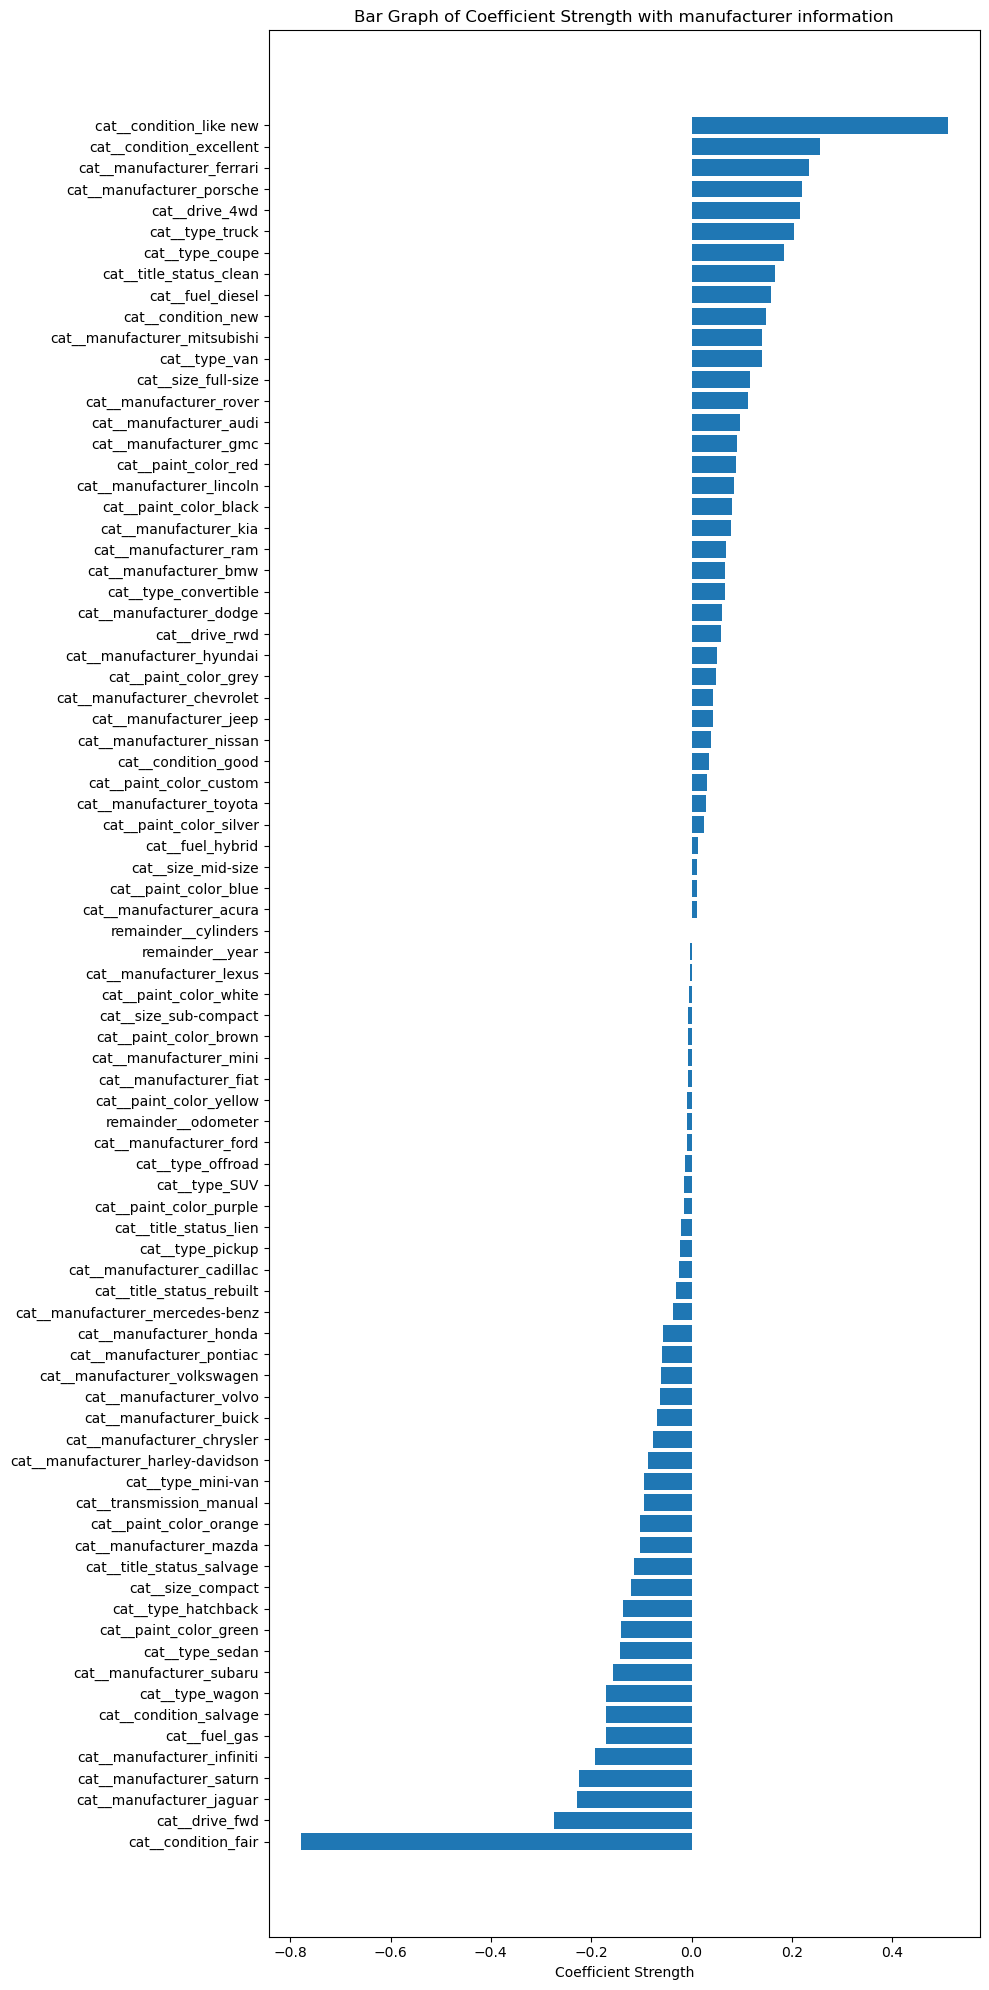

In [266]:
coefs = regressor.coef_
features = best_est.named_steps['transformer'].get_feature_names_out()
coef_df = pd.DataFrame(coefs, index = features, columns = ['coefficient'])
coef_df
# coeff df
all_coefs = pd.DataFrame(coef_df)
# Sort the DataFrame by the 'coefficient' column
all_coefs_sorted = all_coefs.sort_values(by='coefficient', ascending=True)

# Plotting the sorted values
plt.figure(figsize=(10, 20))
plt.barh(all_coefs_sorted.index, all_coefs_sorted['coefficient'])
txt='Bar Graph of Coefficient Strength with manufacturer information'
plt.title(txt)
plt.xlabel('Coefficient Strength')
plt.tight_layout()
# plt.show()
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)

# Displaying the sorted DataFrame
print(all_coefs_sorted)

In [267]:
train_mse = mean_squared_error(model_finder.best_estimator_.predict(X_train), y_train)
test_mse  = mean_squared_error(model_finder.best_estimator_.predict(X_test), y_test)
test_r2   = r2_score(y_test, model_finder.best_estimator_.predict(X_test))
print(f"Training MSE: {train_mse.round(2)}")
print(f"Test MSE: {test_mse.round(2)}")
print(f"Test R^2: {100*test_r2.round(2)}%")

Training MSE: 113285019.1
Test MSE: 55054044.34
Test R^2: 38.0%


In [268]:
preprocessor = best_est.named_steps['transformer']
X_test_transformed = preprocessor.transform(X_test)
ohe_feature_names = preprocessor.get_feature_names_out()
# ohe_feature_names

In [269]:
# Convert sparse matrix to dense numpy array
X_test_dense = X_test_transformed.toarray()

# Now, you can use the converted dense array in permutation_importance function
result = permutation_importance(best_est.named_steps['model'], 
                                X_test_dense, y_test, n_repeats=30, random_state=0)


cat__condition_excellent: 0.150 +/- 0.040
cat__condition_like new: 0.115 +/- 0.049
cat__drive_4wd: 0.106 +/- 0.025
cat__drive_fwd: 0.089 +/- 0.032
cat__title_status_rebuilt: 0.003 +/- 0.001
cat__paint_color_brown: 0.001 +/- 0.000
cat__manufacturer_lexus: 0.000 +/- 0.000


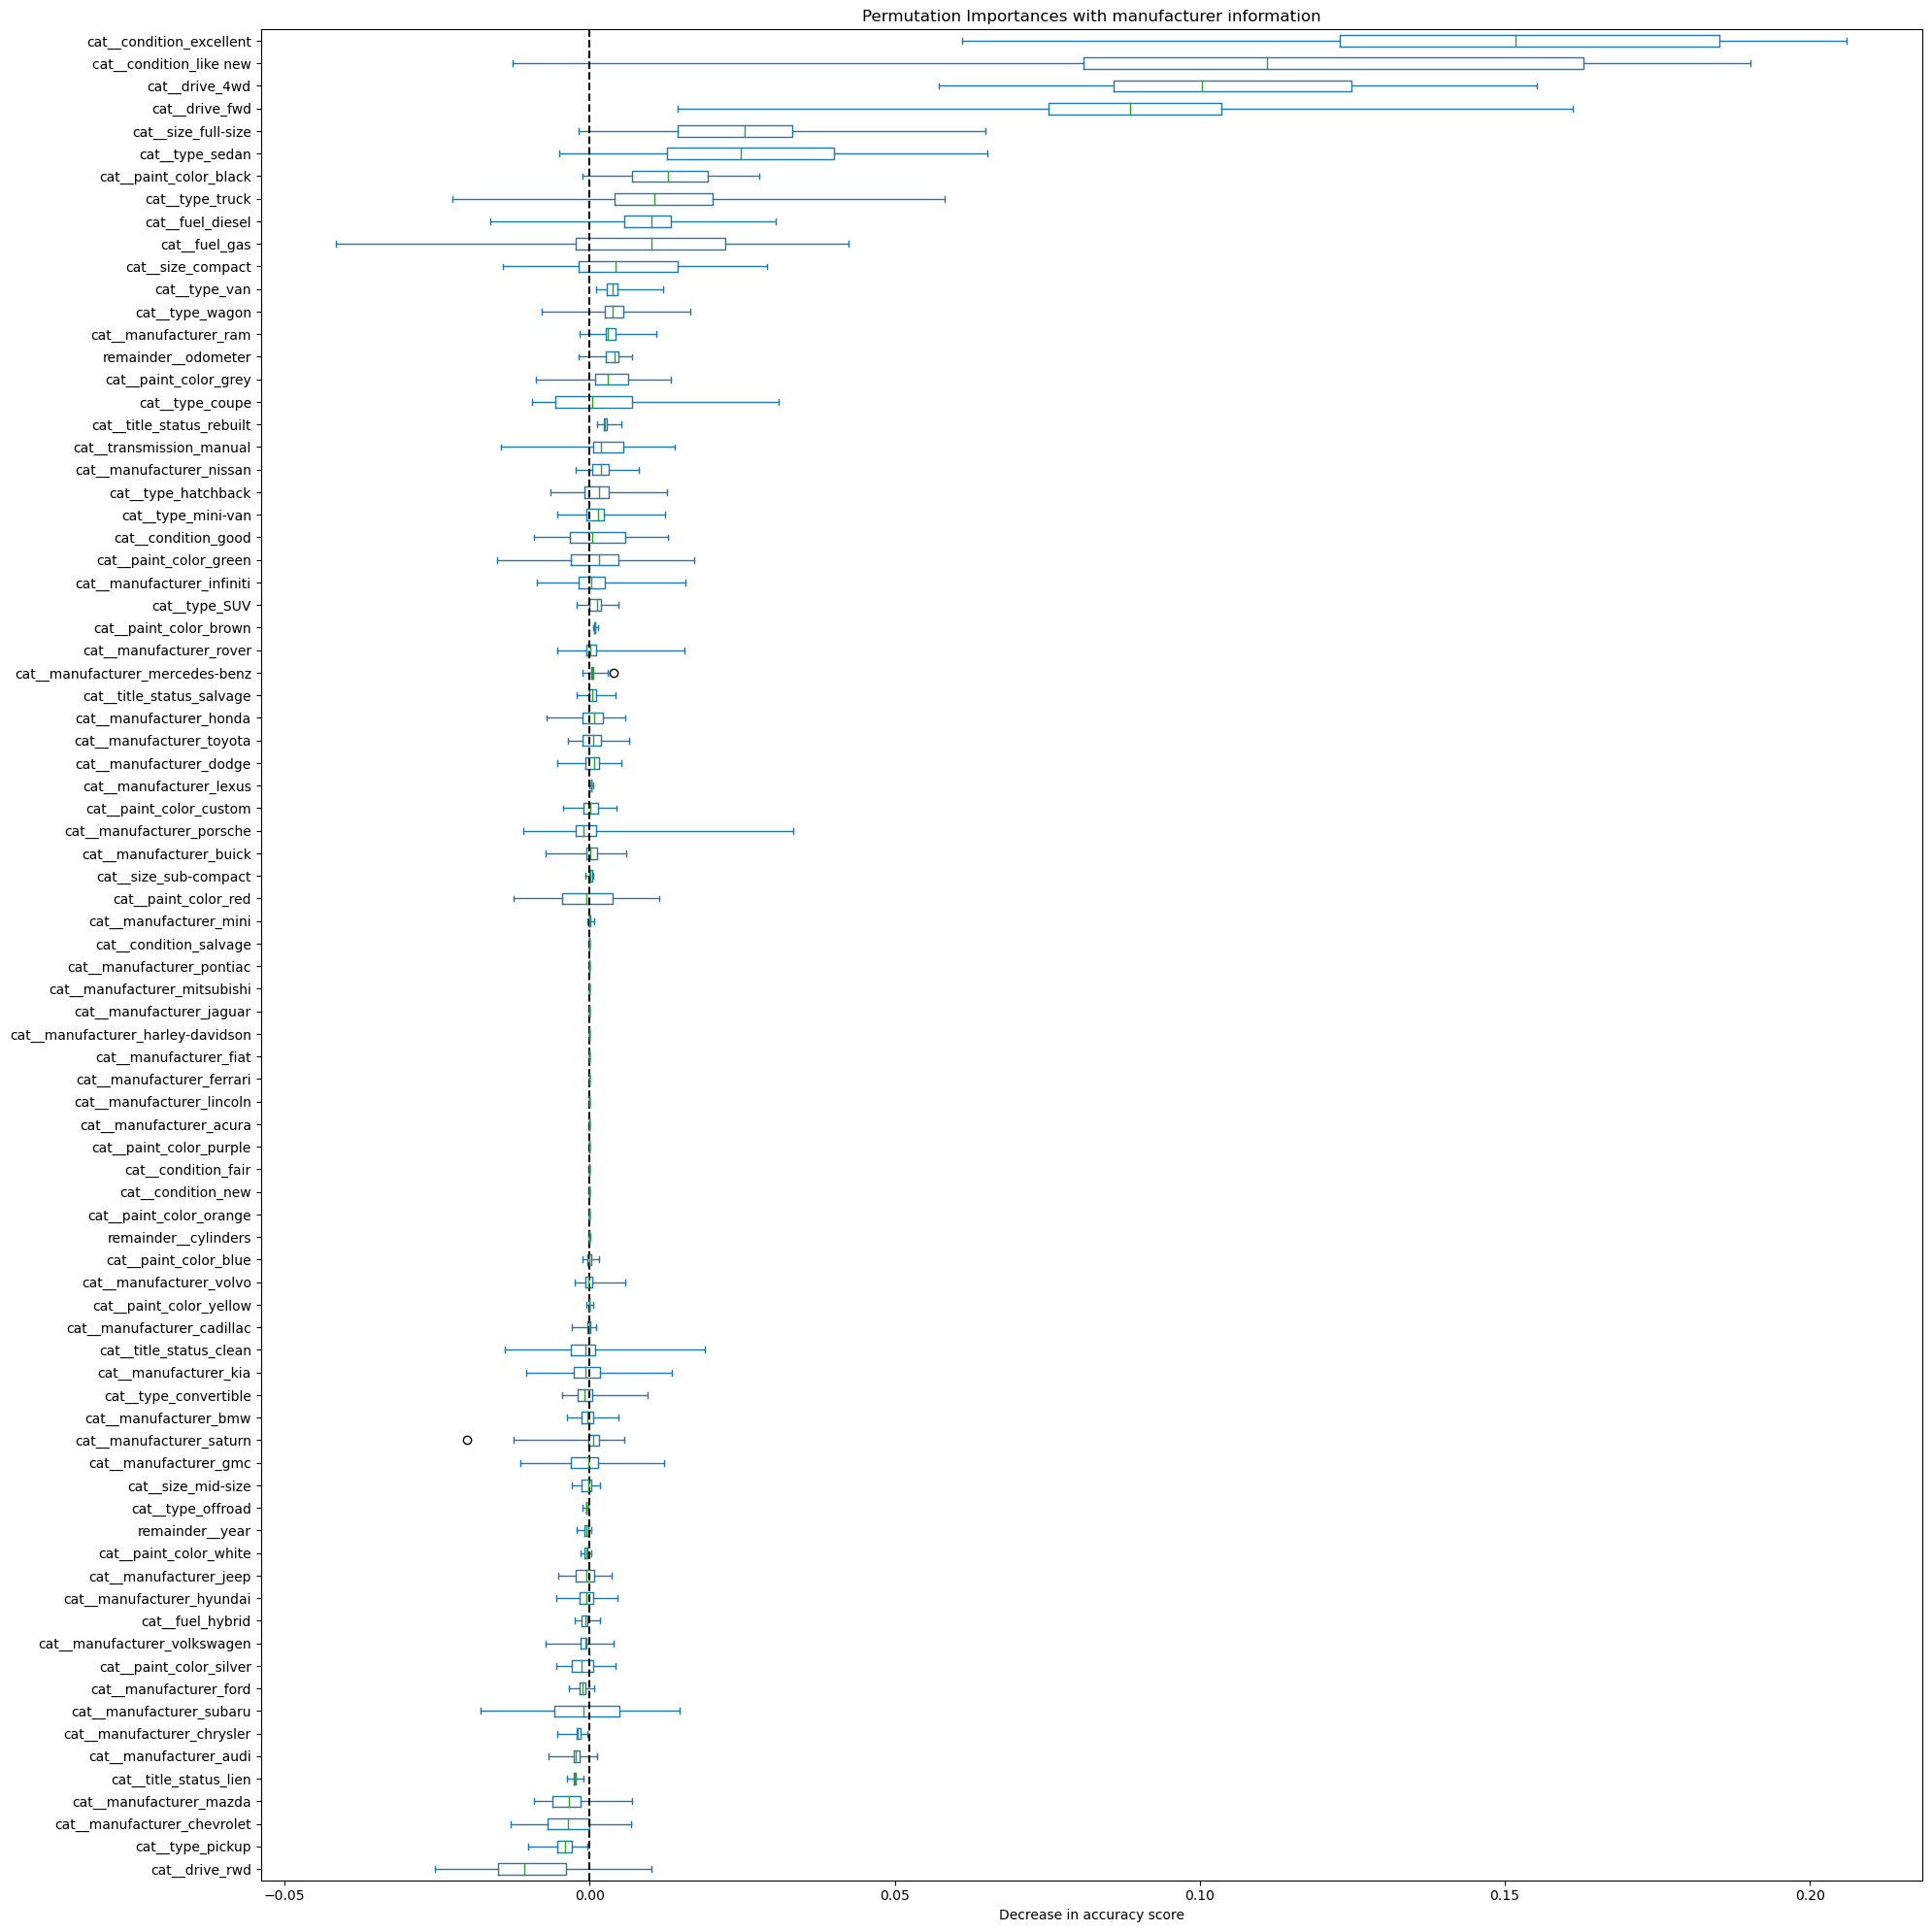

In [270]:
for i in result.importances_mean.argsort()[::-1]:
  if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
    print(f"{ohe_feature_names[i]:<8}: "
          f"{result.importances_mean[i]:.3f}"
          f" +/- {result.importances_std[i]:.3f}")


sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx].T,
                           columns=ohe_feature_names[sorted_importances_idx])


# Plotting the sorted values
ax = importances.plot.box(vert=False, whis=10,figsize=(20, 20))
txt="Permutation Importances with manufacturer information"
ax.set_title(txt)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)

### Repeat above evaluation without Manufacturer 

 

In [271]:
df = df.dropna()
df.sample(3)
df = df.drop(columns=['manufacturer'])

In [272]:
std_columns = ['year', 'odometer', 'cylinders']
data_std = pd.DataFrame(StandardScaler().fit_transform(df[std_columns]), columns = std_columns)
categorical_features = ['condition','fuel','title_status','transmission','drive','size','type','paint_color']
data_std = pd.concat([data_std, df[categorical_features + ['price']]], axis=1)
data_std = data_std.dropna()
data_std.head()

,year,odometer,cylinders,condition,fuel,title_status,transmission,drive,size,type,paint_color,price
215,-0.119628,-0.393647,0.162695,excellent,gas,clean,automatic,fwd,compact,sedan,blue,4000.0
268,1.400766,-1.202469,0.162695,excellent,gas,clean,automatic,rwd,compact,convertible,white,9000.0
346,-1.422823,0.239248,1.409830,good,gas,clean,automatic,rwd,mid-size,convertible,red,98900.0
355,0.749168,-0.726248,0.162695,good,gas,clean,automatic,rwd,full-size,sedan,silver,9400.0
364,-0.771226,0.286668,1.409830,good,gas,clean,automatic,fwd,mid-size,SUV,white,7300.0


In [273]:
# Get the number of rows
num_rows = data_std.shape[0]

# Calculate the split index
split_index = int(num_rows * 0.8)

# Split the DataFrame into training and testing sets
# np.random.seed(42)
# data_train, data_test = np.split(shuffle(data_std), [int(num_rows*.7)], axis=0)

data_train = data_std.iloc[:split_index]
data_test = data_std.iloc[split_index:]
X_train, y_train = data_train.drop('price', axis=1), data_train['price']
X_test, y_test   = data_test.drop('price', axis=1), data_test['price']

print(X_train.columns == X_test.columns)
print(y_train[:5])
X_train.head()

[ True  True  True  True  True  True  True  True  True  True  True]
215     4000.0
268     9000.0
346    98900.0
355     9400.0
364     7300.0
Name: price, dtype: float64


,year,odometer,cylinders,condition,fuel,title_status,transmission,drive,size,type,paint_color
215,-0.119628,-0.393647,0.162695,excellent,gas,clean,automatic,fwd,compact,sedan,blue
268,1.400766,-1.202469,0.162695,excellent,gas,clean,automatic,rwd,compact,convertible,white
346,-1.422823,0.239248,1.409830,good,gas,clean,automatic,rwd,mid-size,convertible,red
355,0.749168,-0.726248,0.162695,good,gas,clean,automatic,rwd,full-size,sedan,silver
364,-0.771226,0.286668,1.409830,good,gas,clean,automatic,fwd,mid-size,SUV,white


In [274]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])


pipe = Pipeline([
    ('transformer', ColumnTransformer(remainder='passthrough', 
                                       transformers=[
                                           ('cat', categorical_transformer, 
                                            ['condition', 'fuel', 
                                             'title_status', 'transmission', 
                                             'drive', 'size', 'type', 'paint_color'])
                                       ])),
    ('model', TransformedTargetRegressor(func=np.log, inverse_func=np.exp, regressor=Ridge()))
])


#param_grid = {'model__regressor__alpha': 10**np.linspace(-5, 4, 10)}
param_grid = {'model__regressor__alpha': np.linspace(0, 10, 30)}

model_finder = GridSearchCV(estimator = pipe,
                            param_grid = param_grid,
                            scoring = 'neg_mean_squared_error',
                            error_score='raise',
                            cv = 10)


In [275]:
model_finder.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['condition',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color'])])),
                                       ('model',
                                        TransformedTargetRegre...
             param_grid={'model__regressor__alpha': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ])},
             scoring='neg_mean_squared_error')

In [276]:
best_est = model_finder.best_estimator_
best_est

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['condition', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=4.827586206896552)))])

In [277]:
regressor = best_est.named_steps['model'].regressor_
regressor

Ridge(alpha=4.827586206896552)

In [278]:
coefs = regressor.coef_
features = best_est.named_steps['transformer'].get_feature_names_out()
coef_df = pd.DataFrame(coefs, index = features, columns = ['coefficient'])
coef_df

,coefficient
cat__condition_excellent,0.295093
cat__condition_fair,-0.886897
cat__condition_good,0.065160
cat__condition_like new,0.557370
cat__condition_new,0.209350
cat__condition_salvage,-0.240077
cat__fuel_diesel,0.154526
cat__fuel_gas,-0.178177
cat__fuel_hybrid,0.023651
cat__title_status_clean,0.178971


In [279]:
train_mse = mean_squared_error(model_finder.best_estimator_.predict(X_train), y_train)
test_mse  = mean_squared_error(model_finder.best_estimator_.predict(X_test), y_test)
test_r2   = r2_score(y_test, model_finder.best_estimator_.predict(X_test))
print(f"Training MSE: {train_mse.round(2)}")
print(f"Test MSE: {test_mse.round(2)}")
print(f"Test Dev R^2: {100*test_r2.round(2)}%")

Training MSE: 116219511.04
Test MSE: 53985684.21
Test Dev R^2: 40.0%


In [280]:
preprocessor = best_est.named_steps['transformer']
X_test_transformed = preprocessor.transform(X_test)
ohe_feature_names = preprocessor.get_feature_names_out()

In [281]:
# Convert sparse matrix to dense numpy array
X_test_dense = X_test_transformed.toarray()
result = permutation_importance(best_est.named_steps['model'], 
                                X_test_dense, y_test, n_repeats=30,random_state=0)


cat__condition_excellent: 0.201 +/- 0.049
cat__condition_like new: 0.137 +/- 0.059
cat__drive_4wd: 0.098 +/- 0.027
cat__drive_fwd: 0.078 +/- 0.033
cat__title_status_rebuilt: 0.002 +/- 0.001
cat__type_offroad: 0.000 +/- 0.000


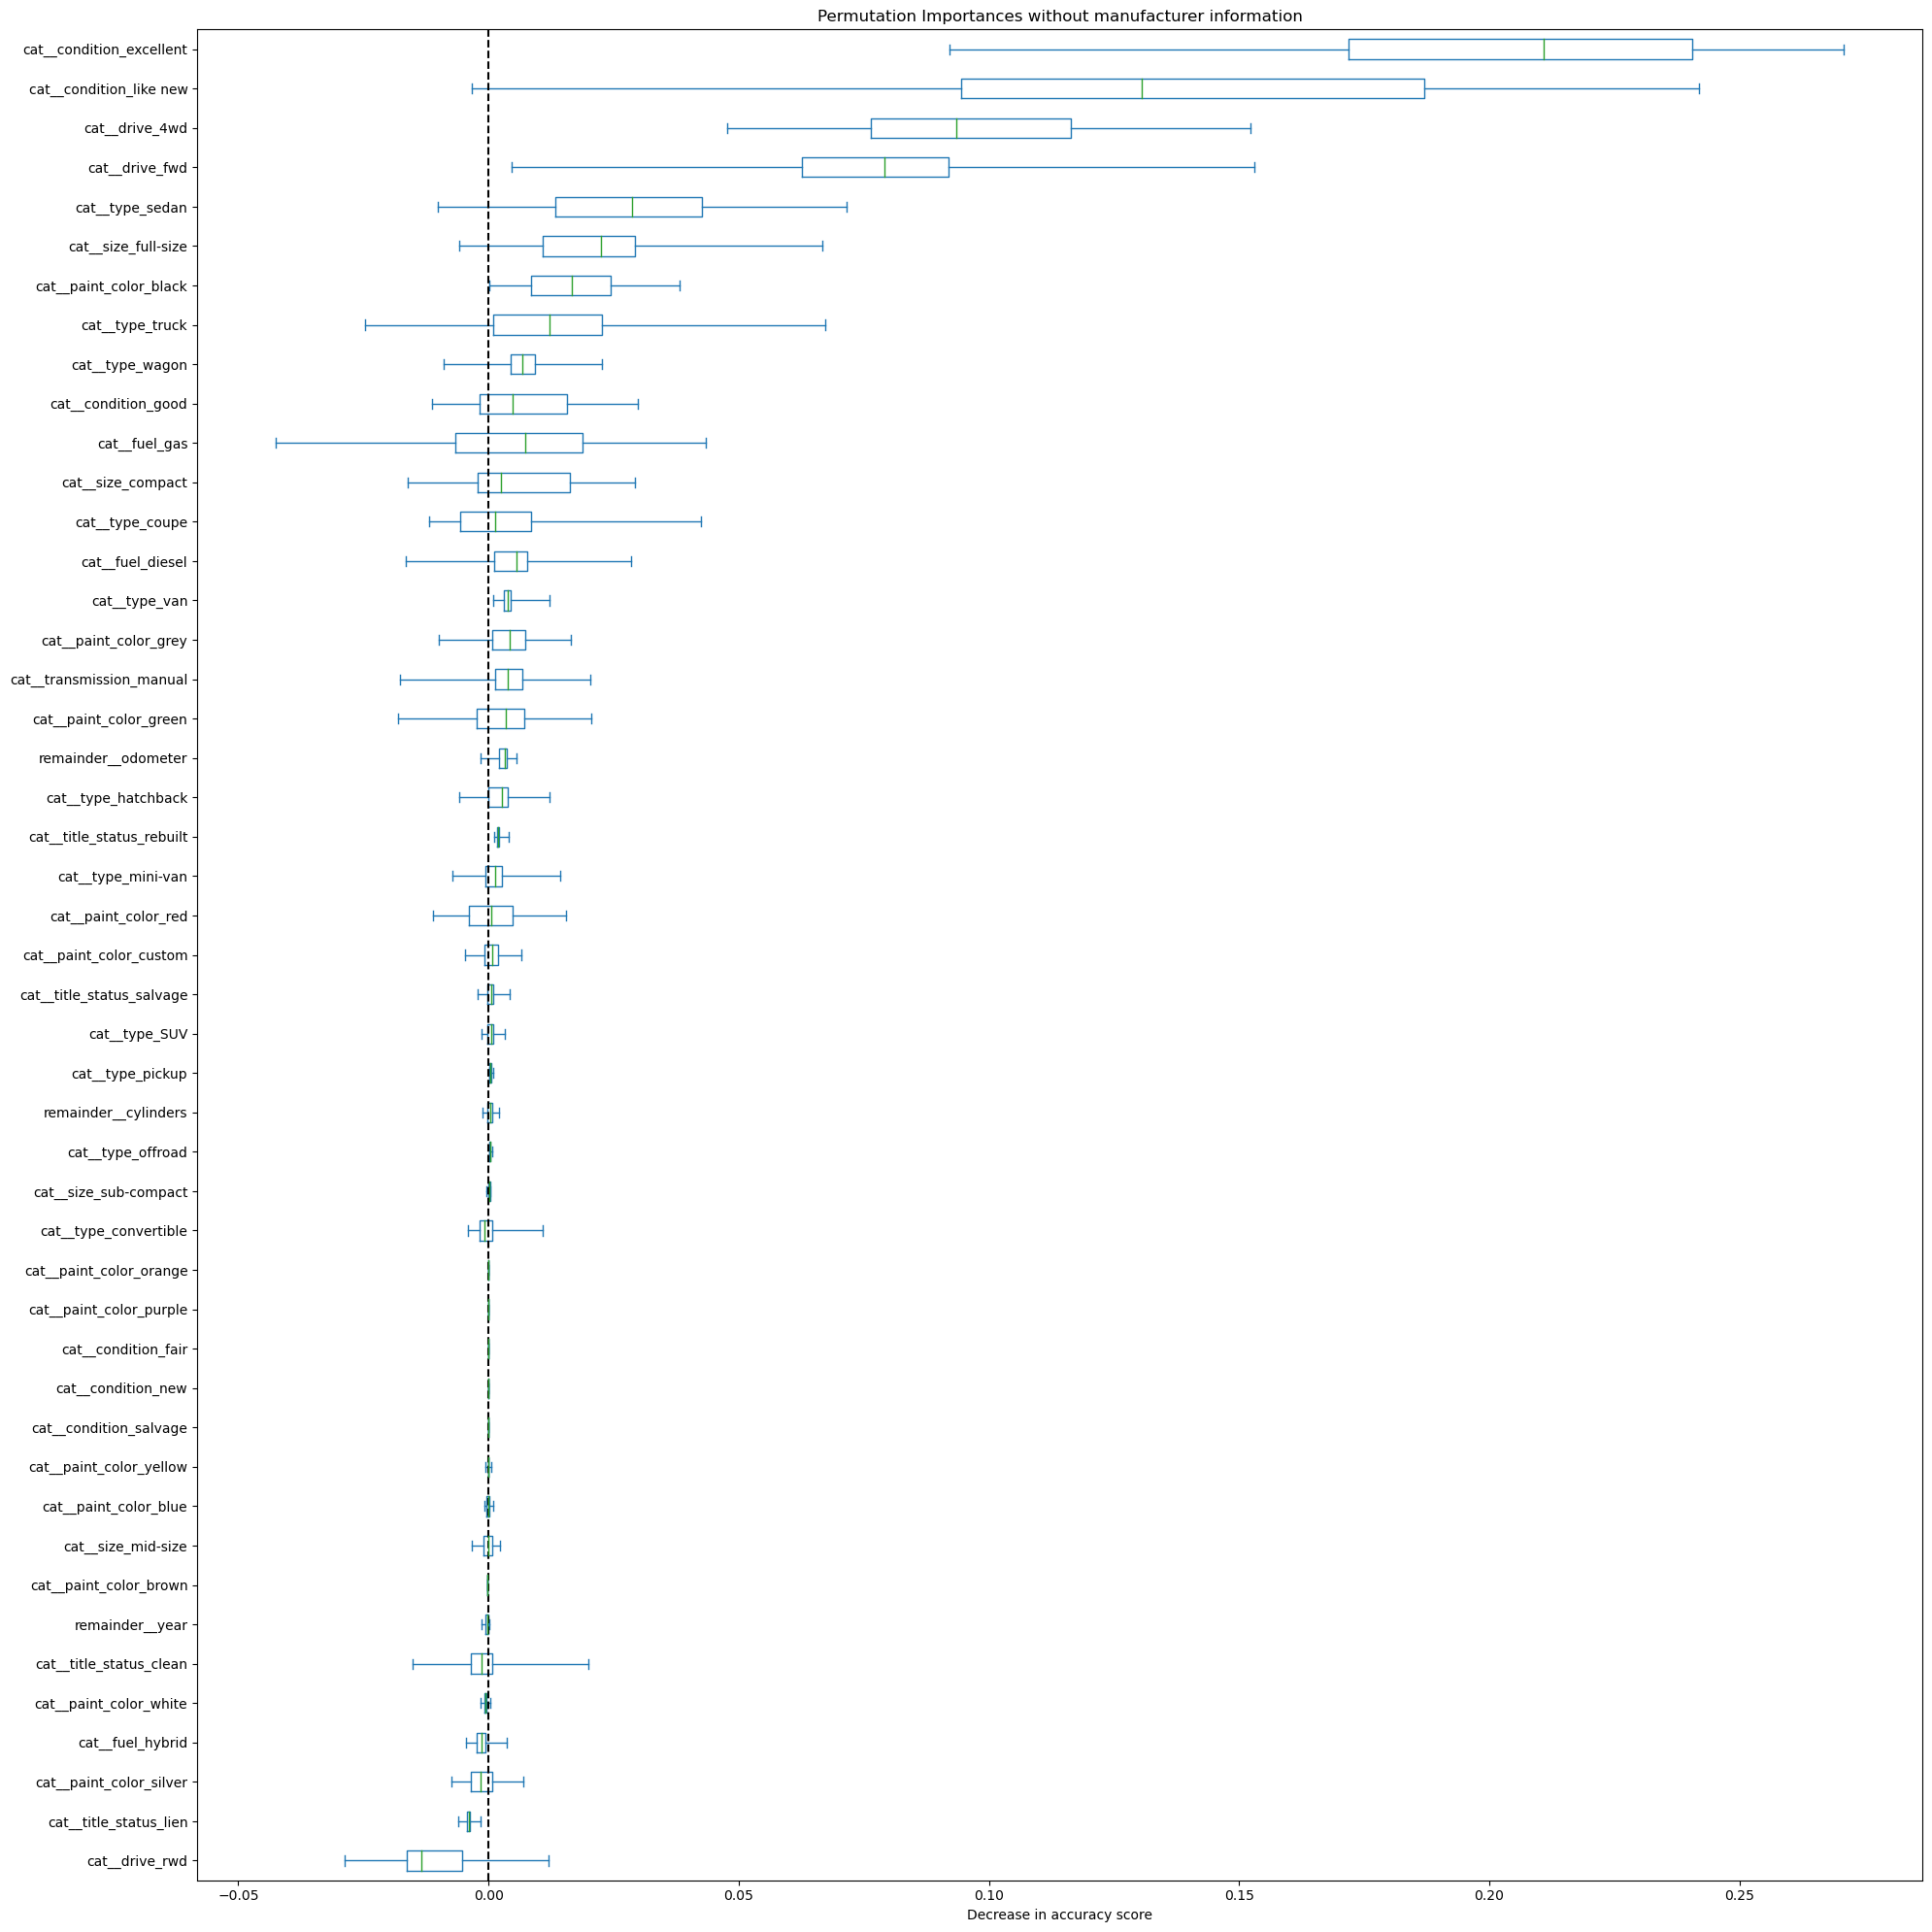

In [282]:
for i in result.importances_mean.argsort()[::-1]:
  if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
    print(f"{ohe_feature_names[i]:<8}: "
          f"{result.importances_mean[i]:.3f}"
          f" +/- {result.importances_std[i]:.3f}")


sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx].T,
                           columns=ohe_feature_names[sorted_importances_idx])


# Plotting the sorted values
ax = importances.plot.box(vert=False, whis=10,figsize=(20, 20))
txt="Permutation Importances without manufacturer information"
ax.set_title(txt)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)

                           coefficient
cat__condition_fair          -0.886897
cat__drive_fwd               -0.279432
cat__condition_salvage       -0.240077
cat__type_wagon              -0.224468
cat__fuel_gas                -0.178177
cat__paint_color_green       -0.163946
cat__type_sedan              -0.156755
cat__type_hatchback          -0.143041
cat__size_compact            -0.127260
cat__title_status_salvage    -0.121899
cat__transmission_manual     -0.113693
cat__type_mini-van           -0.111999
cat__paint_color_orange      -0.110740
cat__title_status_lien       -0.033057
cat__title_status_rebuilt    -0.024014
cat__paint_color_purple      -0.022910
cat__paint_color_yellow      -0.010803
cat__type_SUV                -0.010006
remainder__odometer          -0.008309
cat__paint_color_white       -0.005327
cat__size_sub-compact        -0.004054
remainder__cylinders         -0.003011
remainder__year              -0.001634
cat__paint_color_brown        0.001552
cat__type_pickup         

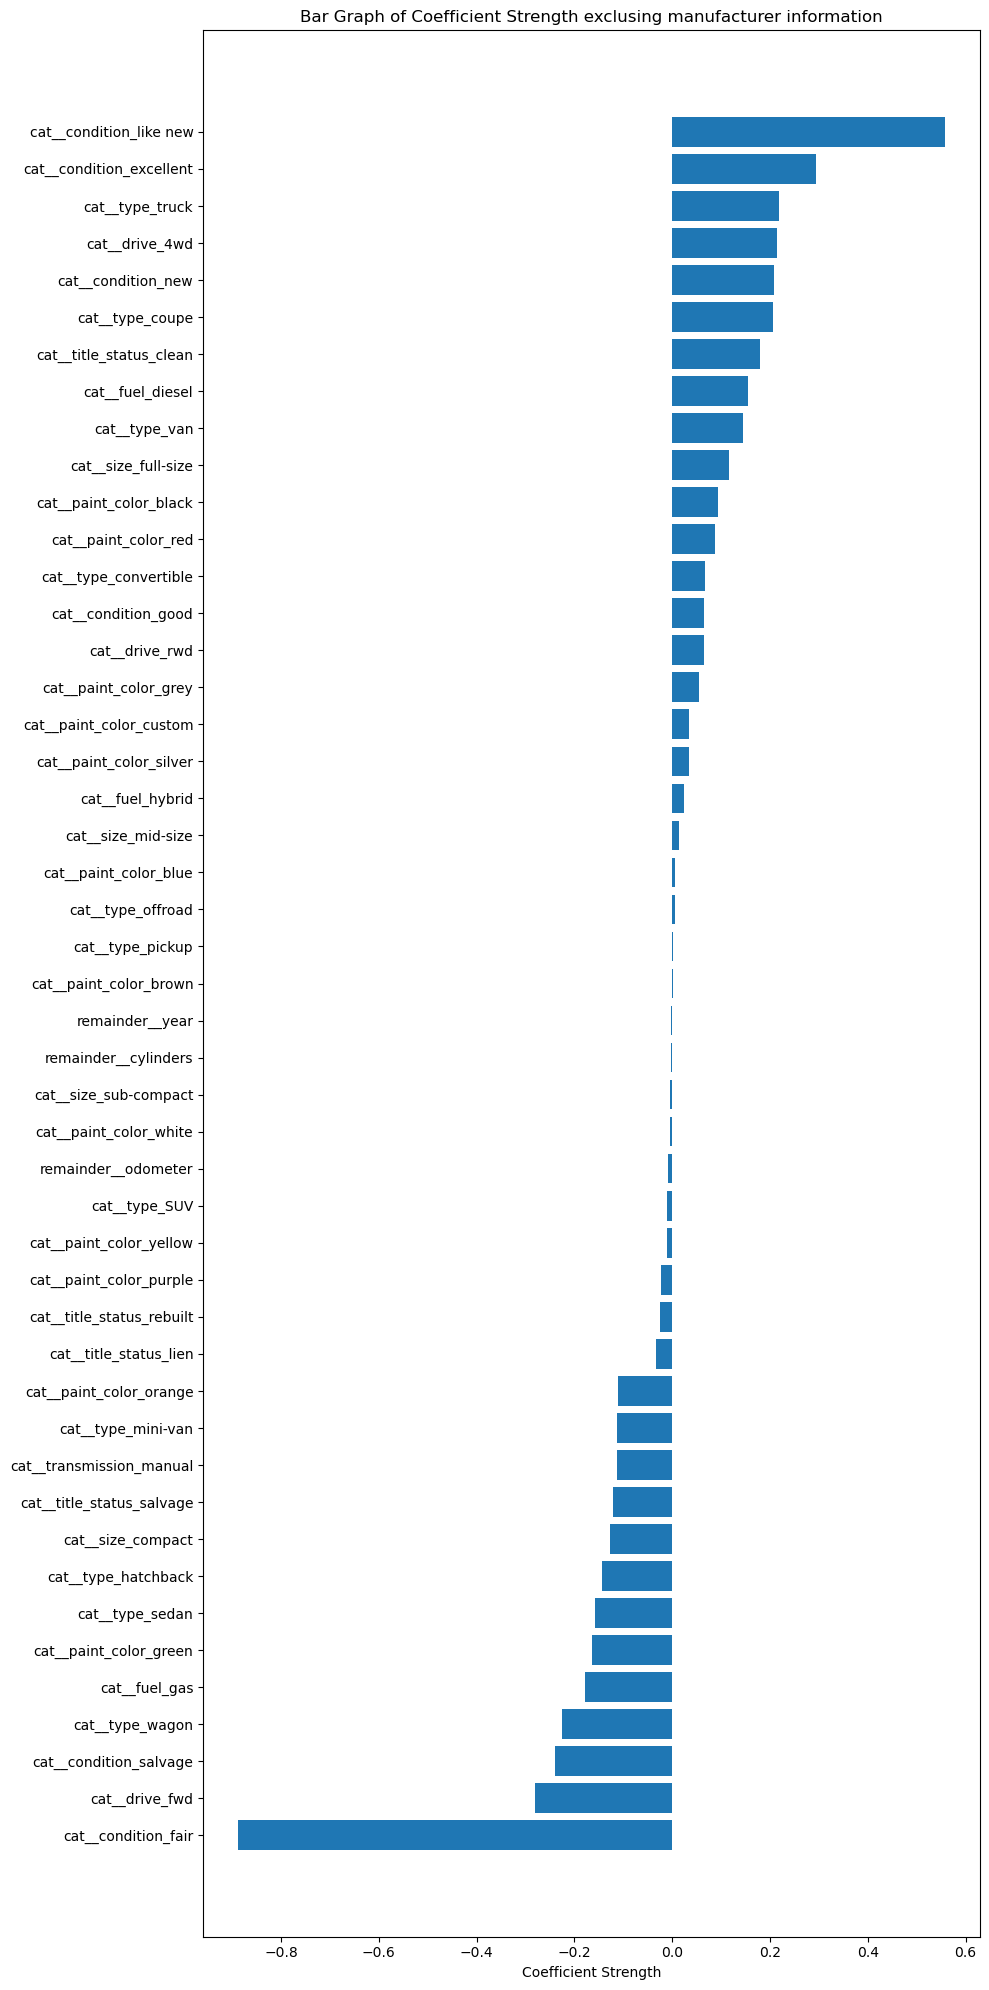

In [283]:
coefs = regressor.coef_
features = best_est.named_steps['transformer'].get_feature_names_out()
coef_df = pd.DataFrame(coefs, index = features, columns = ['coefficient'])
coef_df
# coeff df
all_coefs = pd.DataFrame(coef_df)
# Sort the DataFrame by the 'coefficient' column
all_coefs_sorted = all_coefs.sort_values(by='coefficient', ascending=True)

# Plotting the sorted values
plt.figure(figsize=(10, 20))
plt.barh(all_coefs_sorted.index, all_coefs_sorted['coefficient'])
txt ='Bar Graph of Coefficient Strength exclusing manufacturer information'
plt.title(txt)
plt.xlabel('Coefficient Strength')
plt.tight_layout()
# plt.show()
file_format=".png"   # Change the filename and format as needed
image_filename = txt+file_format
image_path = os.path.join(images_dir, image_filename)
plt.savefig(image_path)

# Displaying the sorted DataFrame
print(all_coefs_sorted)

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.